In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


> Task summary - 

To forecast future web traffic as time series for approximately 145,000 wikipedia articles.

> Concepts

- Univariate models are statistical analysis approaches that involve the analysis of a single dependent variable. Only one variable varies over time. For ex- Sensor measuring temperature of a room per second.

- Multi variate analysis examines two or more dependent variables and multiple independent variables. Multiple variables are varying over time

- Time series is a data that occurs chronologically one after the other.
- Time series forecasting is using the data of the past to detect the future.
- Forecasting values in dynamic system(i.e source of values is dynamic) is hard.
- Every being, global event, their lives are dynamic system for the web traffic. For example - Whenever a semester starts in a university then that corresponding major's wikipedia may be getting a hit to know more about it.

- We usually tend to remove anomaly from time series dataset i.e abnormal behaviour.

> Steps

1. Data cleaning.
2. Visualisation.
3. Remove anomalies.
4. Apply ARMA Model.
5. Apply ARIMA Model.
6. Apply Exponential Smoothing Model.
7. Apply Prophet approach(fbprophet, future)
8. Apply Auto Arima.
9. Apply DL Model(LSTM).
10. Apply DL model(CNN1D).

In [29]:
!pip install statsmodels


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [30]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
!pip install seaborn

import seaborn as sns
import scipy
from datetime import timedelta
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from fbprophet import Prophet
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow import keras

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import r2_score
import re

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [31]:
!unzip /kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


Archive:  /kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip
replace train_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [32]:
!ls

train_1.csv


In [33]:
data_path = "train_1.csv"


In [34]:
df = pd.read_csv(data_path)
df.head()
# these are page views per days spread across various columns

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


## 1. Data Cleaning

In [35]:
# Fill missing values
df = df.fillna(0)

In [36]:
# sept to dec data
train_data = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Visits')
train_data.head()

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [37]:
train_data['Date'] = pd.DatetimeIndex(train_data['Date'])
train_data

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0
...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0


## 2. Data Visualization

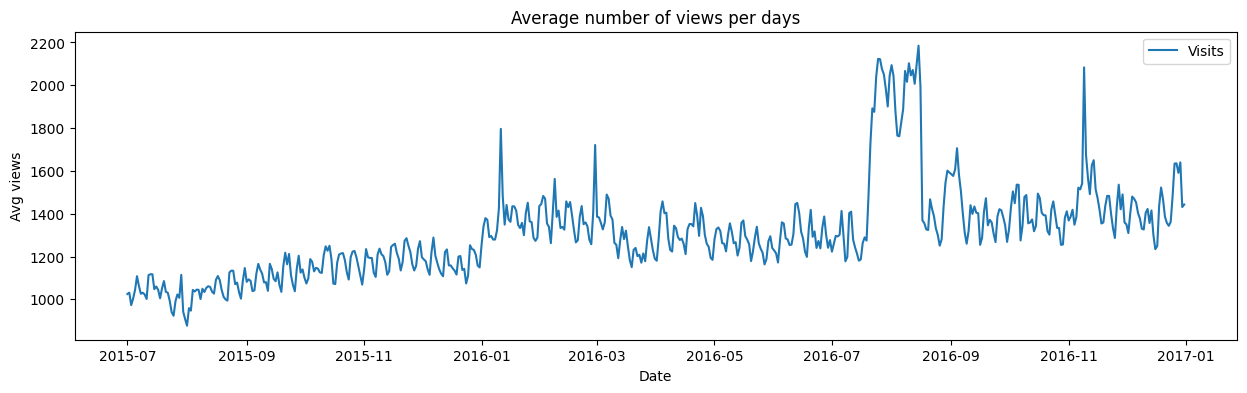

In [38]:
#visualising
temp = train_data.groupby('Date')['Visits'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per days')
plt.plot(temp,label='Visits')
plt.legend()
plt.show()

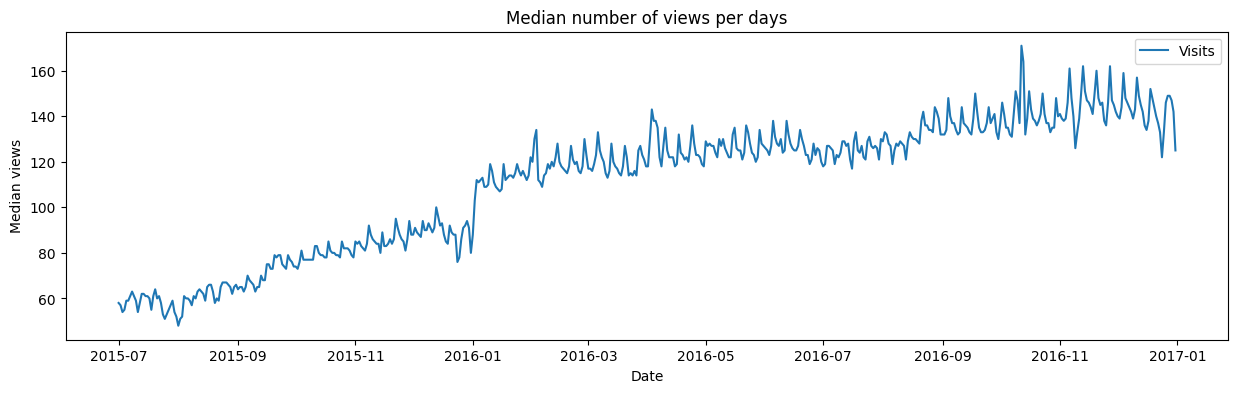

In [39]:
#visualising
temp = train_data.groupby('Date')['Visits'].median()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Median views')
plt.title('Median number of views per days')
plt.plot(temp,label='Visits')
plt.legend()
plt.show()

In [40]:
train_data

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0
...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0


In [41]:
train_data['year']=train_data.Date.dt.year 
train_data['month']=train_data.Date.dt.month 
train_data['day']=train_data.Date.dt.day

In [42]:
#plotting web traffic over days of month using heatmap
# data is of 9th month to 12th
train_data['month_num'] = train_data['month']
train_data['month'].replace('9','9 - September',inplace=True)
train_data['month'].replace('10','10 - October',inplace=True)
train_data['month'].replace('11','11 - November',inplace=True)
train_data['month'].replace('12','12 - December',inplace=True)

In [43]:
train_data


,Page,Date,Visits,year,month,day,month_num
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,2015,7,1,7
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,2015,7,1,7
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,2015,7,1,7
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,2015,7,1,7
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0,2015,7,1,7
...,...,...,...,...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0,2016,12,31,12
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0,2016,12,31,12
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0,2016,12,31,12
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0,2016,12,31,12


In [44]:
train_data['weekday'] = train_data['Date'].apply(lambda x: x.weekday())


In [45]:
train_data['weekday#'] = train_data['weekday']
train_data['weekday'].replace(0,'01 - Monday',inplace=True)
train_data['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_data['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_data['weekday'].replace(3,'04 - Thursday',inplace=True)
train_data['weekday'].replace(4,'05 - Friday',inplace=True)
train_data['weekday'].replace(5,'06 - Saturday',inplace=True)
train_data['weekday'].replace(6,'07 - Sunday',inplace=True)

In [46]:
train_data


,Page,Date,Visits,year,month,day,month_num,weekday,weekday#
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,2015,7,1,7,03 - Wednesday,2
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,2015,7,1,7,03 - Wednesday,2
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,2015,7,1,7,03 - Wednesday,2
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,2015,7,1,7,03 - Wednesday,2
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0,2015,7,1,7,03 - Wednesday,2
...,...,...,...,...,...,...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0,2016,12,31,12,06 - Saturday,5
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0,2016,12,31,12,06 - Saturday,5
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0,2016,12,31,12,06 - Saturday,5
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0,2016,12,31,12,06 - Saturday,5


In [57]:
train_group = train_data.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group

,month,weekday,Visits
0,1,01 - Monday,1513.386099
1,1,02 - Tuesday,1387.743387
2,1,03 - Wednesday,1338.449062
3,1,04 - Thursday,1335.111541
4,1,05 - Friday,1307.738341
...,...,...,...
79,12,03 - Wednesday,1290.200544
80,12,04 - Thursday,1271.235403
81,12,05 - Friday,1239.405814
82,12,06 - Saturday,1263.923195


In [60]:
train_group = train_group.pivot(index='weekday',columns='month',values='Visits')
train_group.sort_index(inplace=True)

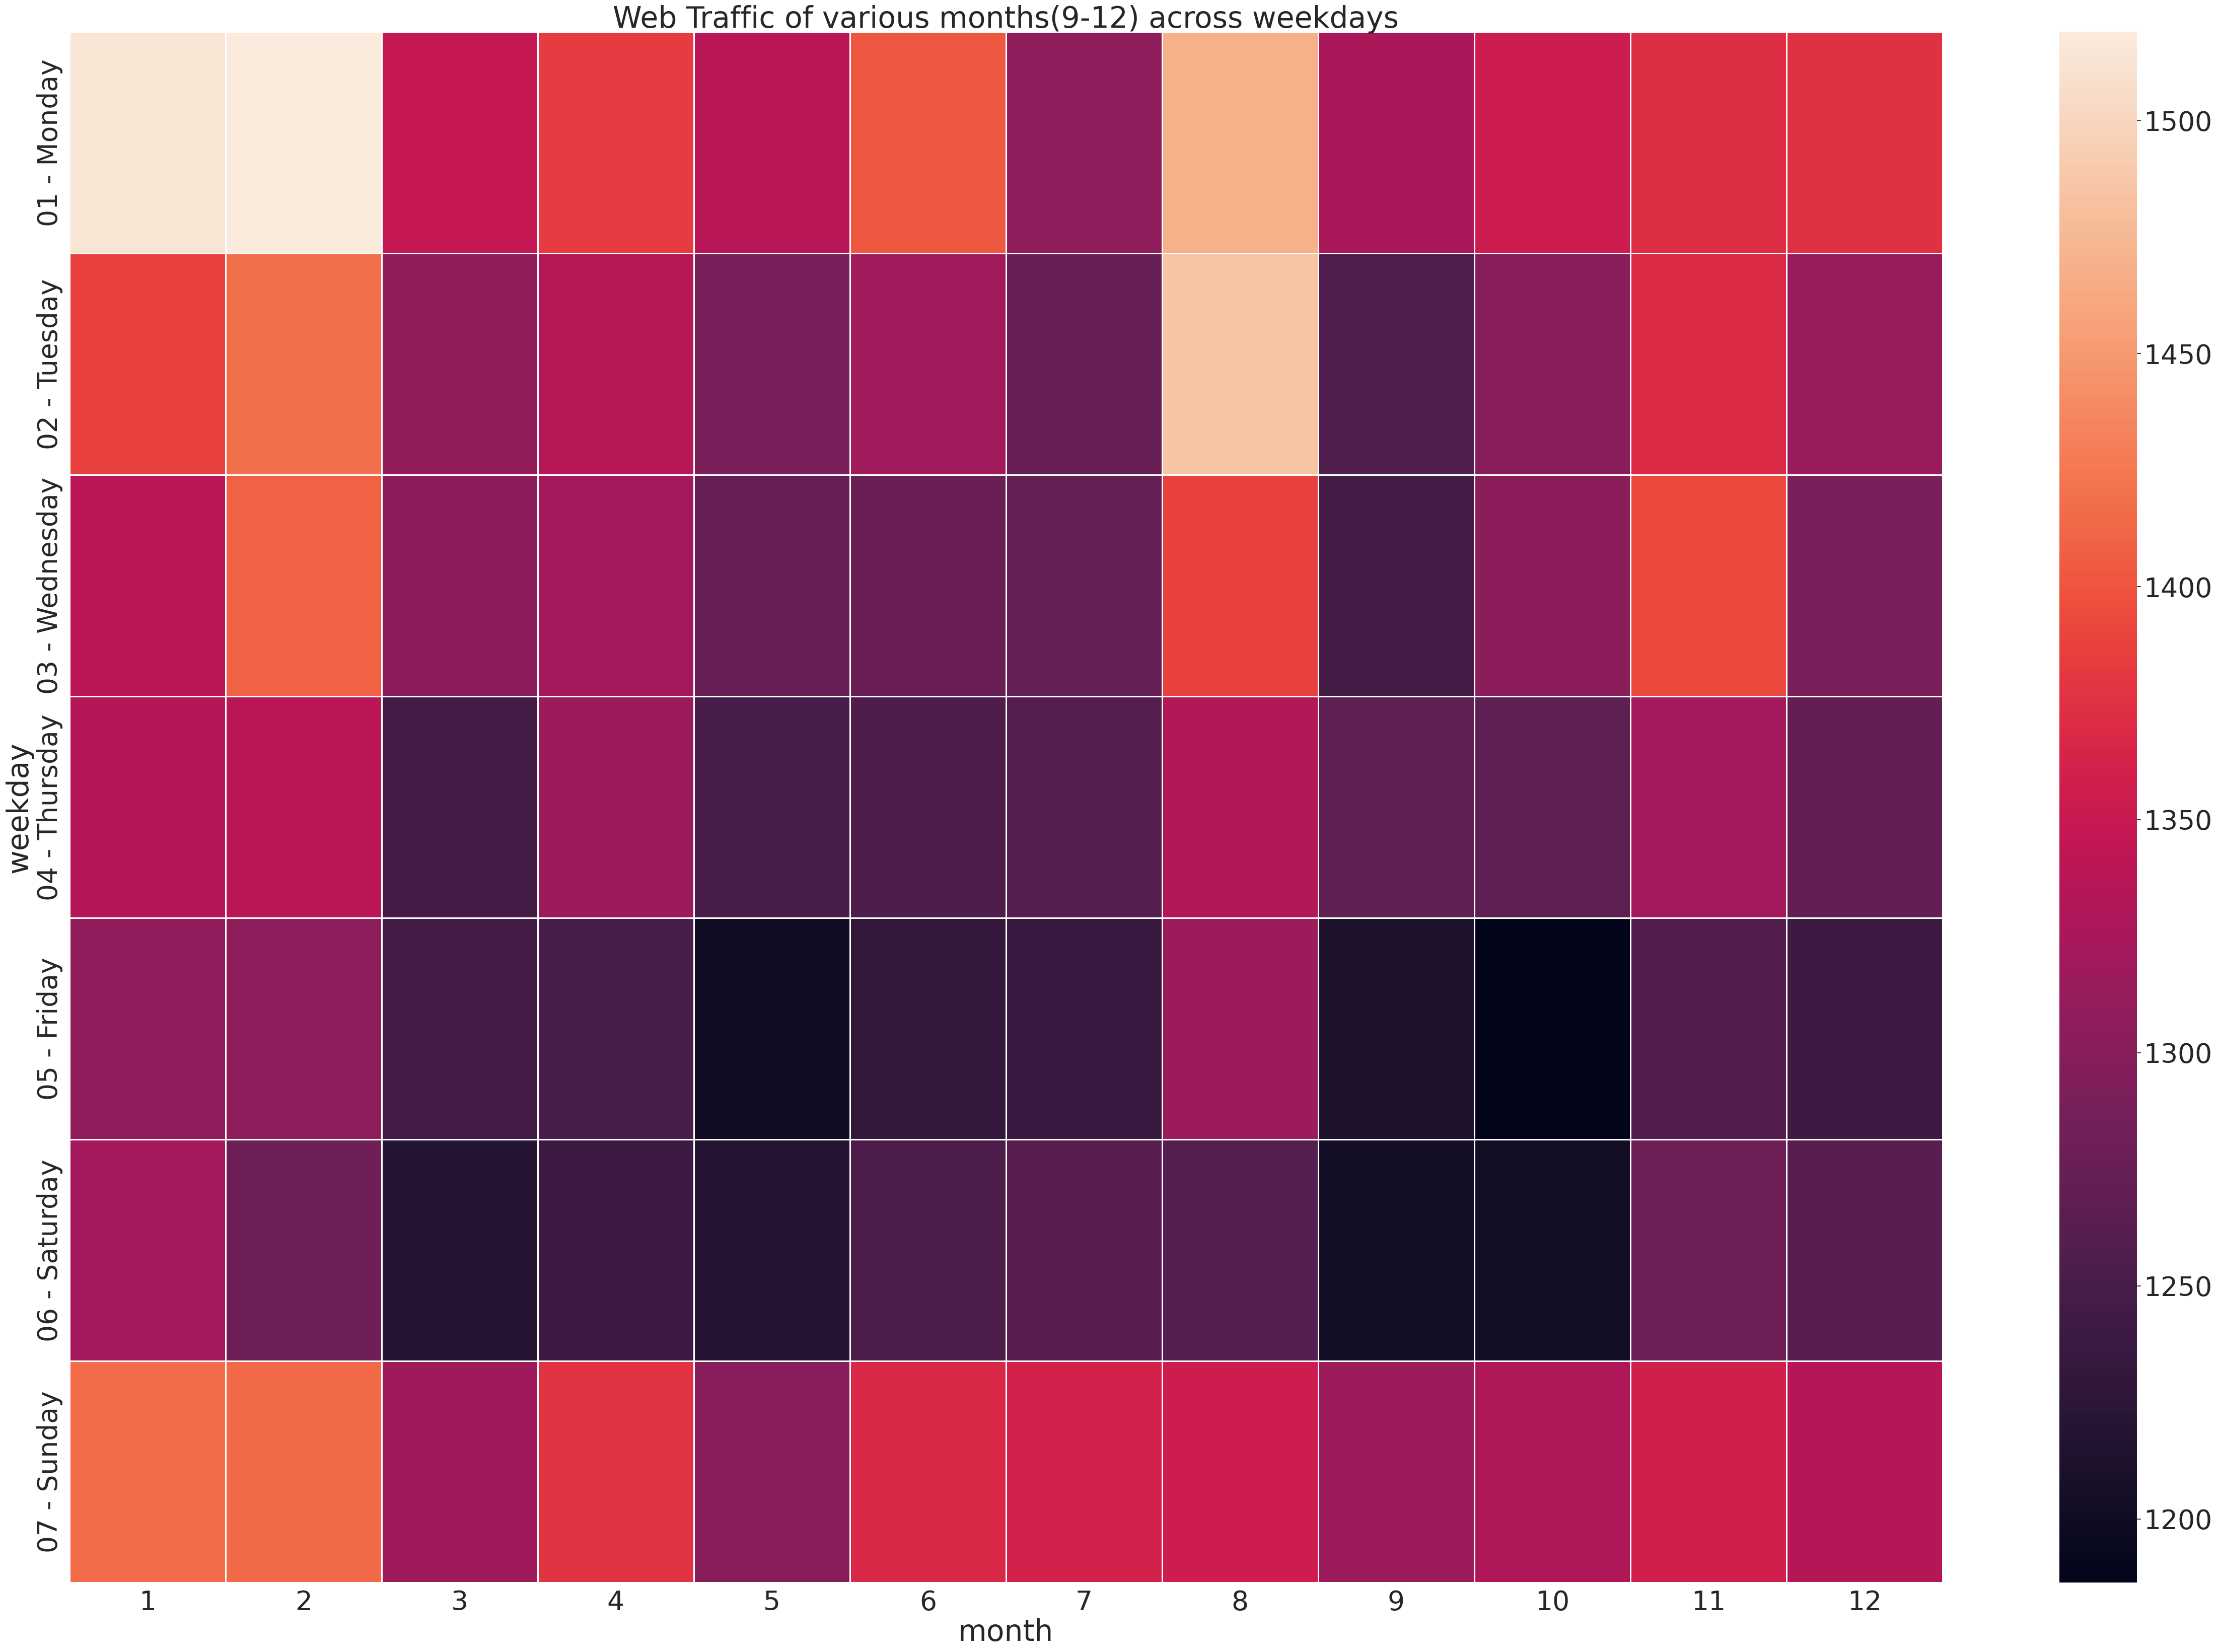

In [61]:
sns.set(font_scale=3.5) 
f, ax = plt.subplots(figsize=(60, 40))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic of various months(9-12) across weekdays')
plt.show()

We can see that the traffic is maximum on fridays and saturdays on most of the months during the span of Sept to Dec.



In [62]:
cols_to_drop = ['year','month','day','month_num','weekday','weekday','weekday#']
train_data.drop(cols_to_drop,axis=1,inplace=True)
train_data


,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0
...,...,...,...
79784645,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0
79784646,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,0.0
79784647,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,0.0
79784648,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,0.0


In [63]:
# top 5 pages with maximum number of views
top_pages = train_data.groupby('Page')['Visits'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Visits')['Page'].tolist()

In [64]:
top5_pages_df = train_data[train_data['Page'].isin(top_pages_list)]
top5_pages_df

,Page,Date,Visits
9774,Main_Page_en.wikipedia.org_desktop_all-agents,2015-07-01,11952559.0
38573,Main_Page_en.wikipedia.org_all-access_all-agents,2015-07-01,20381245.0
39180,Special:Search_en.wikipedia.org_all-access_all...,2015-07-01,2034850.0
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-07-01,8039732.0
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-07-01,2983623.0
...,...,...,...
79649361,Main_Page_en.wikipedia.org_desktop_all-agents,2016-12-31,19591761.0
79678160,Main_Page_en.wikipedia.org_all-access_all-agents,2016-12-31,26149541.0
79678767,Special:Search_en.wikipedia.org_all-access_all...,2016-12-31,1576945.0
79713701,Main_Page_en.wikipedia.org_mobile-web_all-agents,2016-12-31,3939419.0


In [65]:
#detecting language across page
def detect_language(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'

In [66]:
temp1 = train_data
temp1['Wikipedia_page'] = temp1.Page.apply(detect_language)

In [67]:
def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'

In [68]:
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)


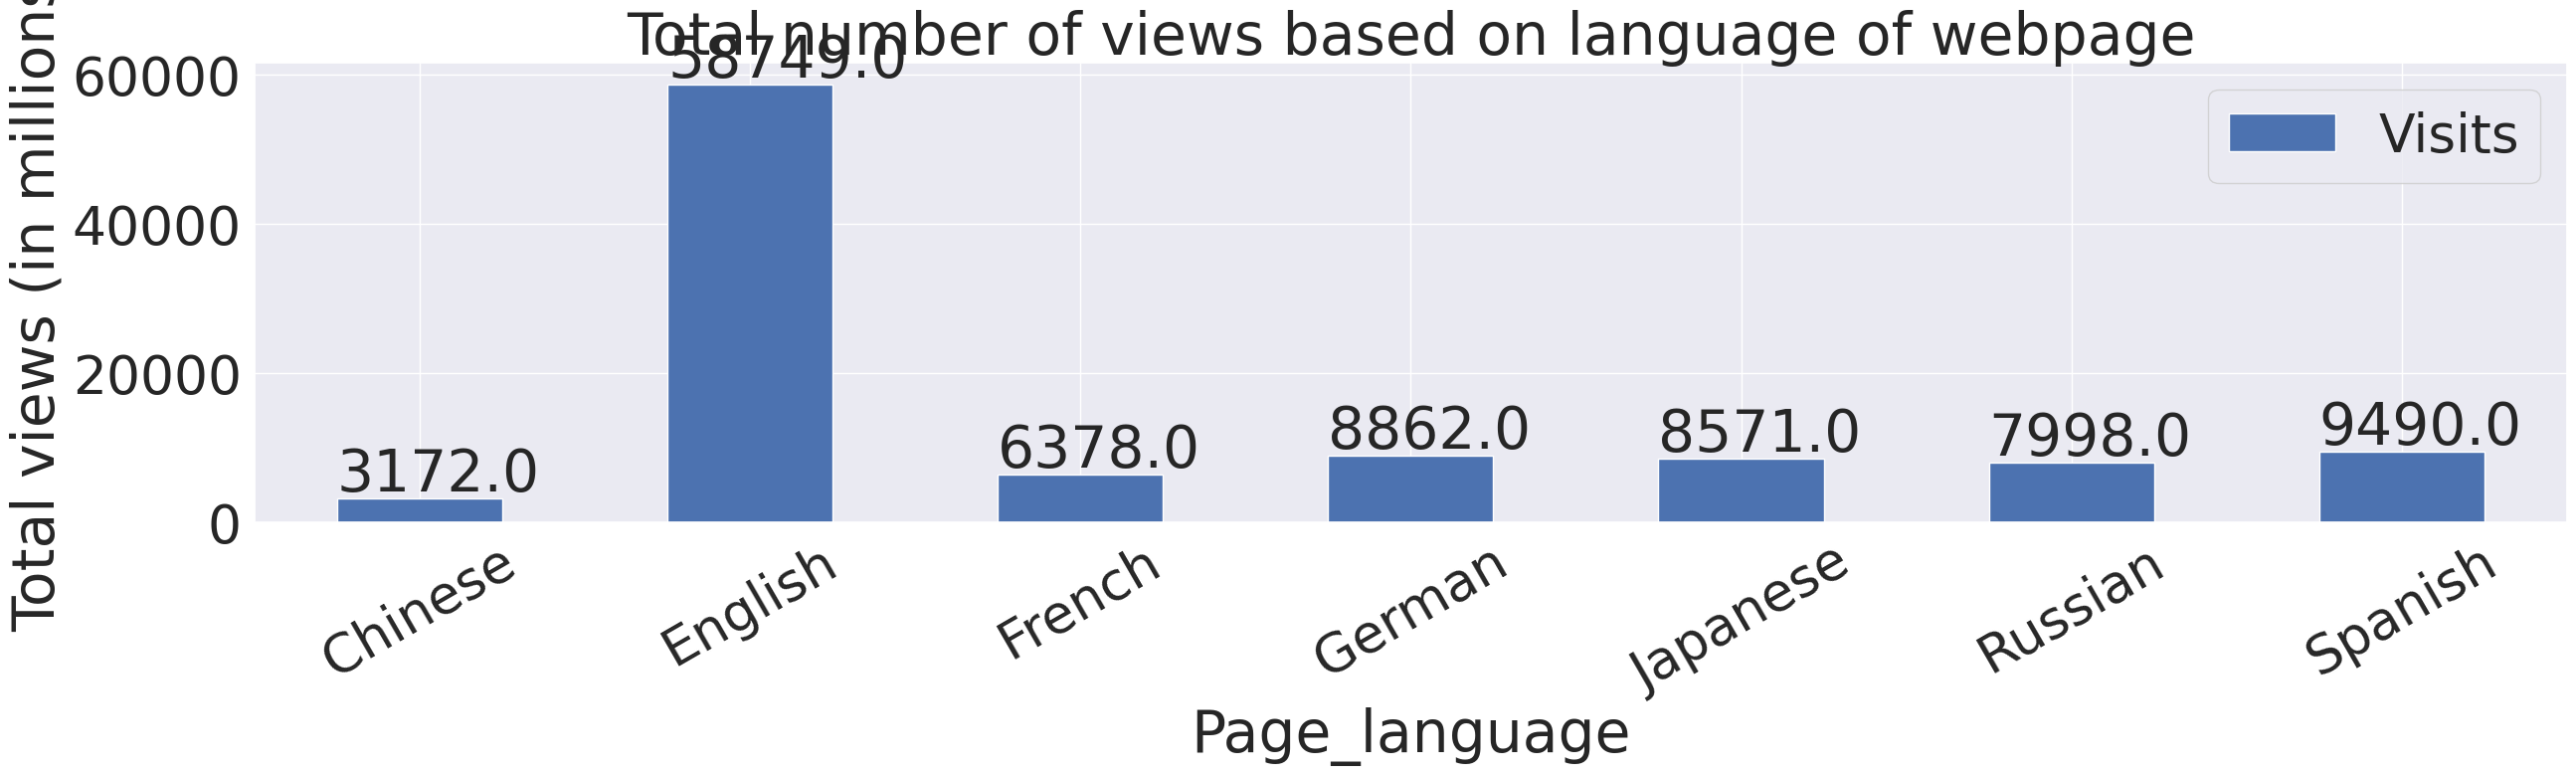

In [69]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(30,6))
lang_df = temp1.groupby('Page_language')['Visits'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Visits'] = round(lang_df['Visits']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Visits',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [70]:
top_pages = train_data.groupby('Page')['Visits'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Visits')['Page'].tolist()
print(top_pages_list)

['Main_Page_en.wikipedia.org_all-access_all-agents', 'Main_Page_en.wikipedia.org_desktop_all-agents', 'Main_Page_en.wikipedia.org_mobile-web_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 'Special:Search_en.wikipedia.org_all-access_all-agents']


In [71]:
top5_pages_df = train_data[train_data['Page'].isin(top_pages_list)]


In [72]:
top5_pages_df


,Page,Date,Visits,Wikipedia_page,Page_language
9774,Main_Page_en.wikipedia.org_desktop_all-agents,2015-07-01,11952559.0,en,English
38573,Main_Page_en.wikipedia.org_all-access_all-agents,2015-07-01,20381245.0,en,English
39180,Special:Search_en.wikipedia.org_all-access_all...,2015-07-01,2034850.0,en,English
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,2015-07-01,8039732.0,en,English
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2015-07-01,2983623.0,de,German
...,...,...,...,...,...
79649361,Main_Page_en.wikipedia.org_desktop_all-agents,2016-12-31,19591761.0,en,English
79678160,Main_Page_en.wikipedia.org_all-access_all-agents,2016-12-31,26149541.0,en,English
79678767,Special:Search_en.wikipedia.org_all-access_all...,2016-12-31,1576945.0,en,English
79713701,Main_Page_en.wikipedia.org_mobile-web_all-agents,2016-12-31,3939419.0,en,English


In [73]:
# Time-series of page with maximum views
top_page_df = train_data[train_data.Page == top_pages_list[0]]
#top_page_df = top_page_df['Visits']
top_page_df['Visits'] = top_page_df['Visits'].div(1000000).round(2)
top_page_df.drop(['Page','Wikipedia_page','Page_language'],axis=1,inplace=True)
top_page_df.head()

/tmp/ipykernel_15/2886216711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_page_df['Visits'] = top_page_df['Visits'].div(1000000).round(2)
/tmp/ipykernel_15/2886216711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_page_df.drop(['Page','Wikipedia_page','Page_language'],axis=1,inplace=True)


,Date,Visits
38573,2015-07-01,20.38
183636,2015-07-02,20.75
328699,2015-07-03,19.57
473762,2015-07-04,20.44
618825,2015-07-05,20.77


In [74]:
top_page_df.reset_index(inplace=True)


In [75]:
top_page_df.head()


,index,Date,Visits
0,38573,2015-07-01,20.38
1,183636,2015-07-02,20.75
2,328699,2015-07-03,19.57
3,473762,2015-07-04,20.44
4,618825,2015-07-05,20.77


In [76]:
top_page_df.drop('index',axis=1,inplace=True)


/tmp/ipykernel_15/2429970149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_page_df.drop('index',axis=1,inplace=True)


In [77]:
top_page_df = top_page_df.set_index('Date')
top_page_df.head()

,Visits
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


<Axes: xlabel='Date'>

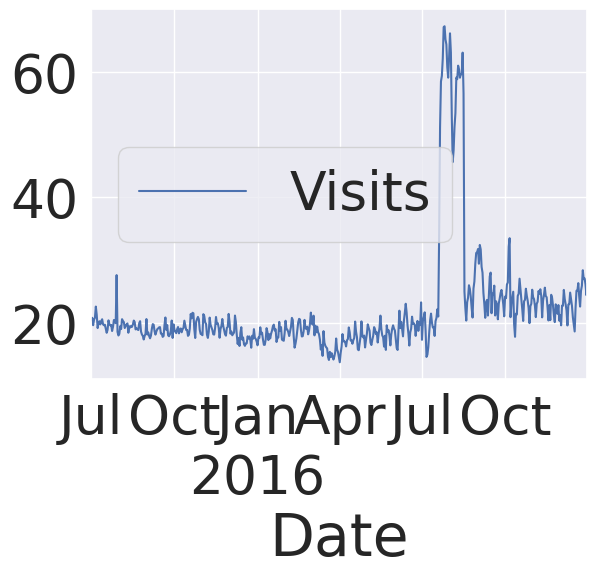

In [78]:
top_page_df.plot()


## 3. Anomaly Detection
Using isolation forest since as seen in the figure above, There are anomalies in the data. Using data with anomalies for forecasting will affect the accuracy of the model. Hence anomalies are removed using Isolation forest.

In [79]:
isolation_forest_model = IsolationForest(contamination=0.05)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

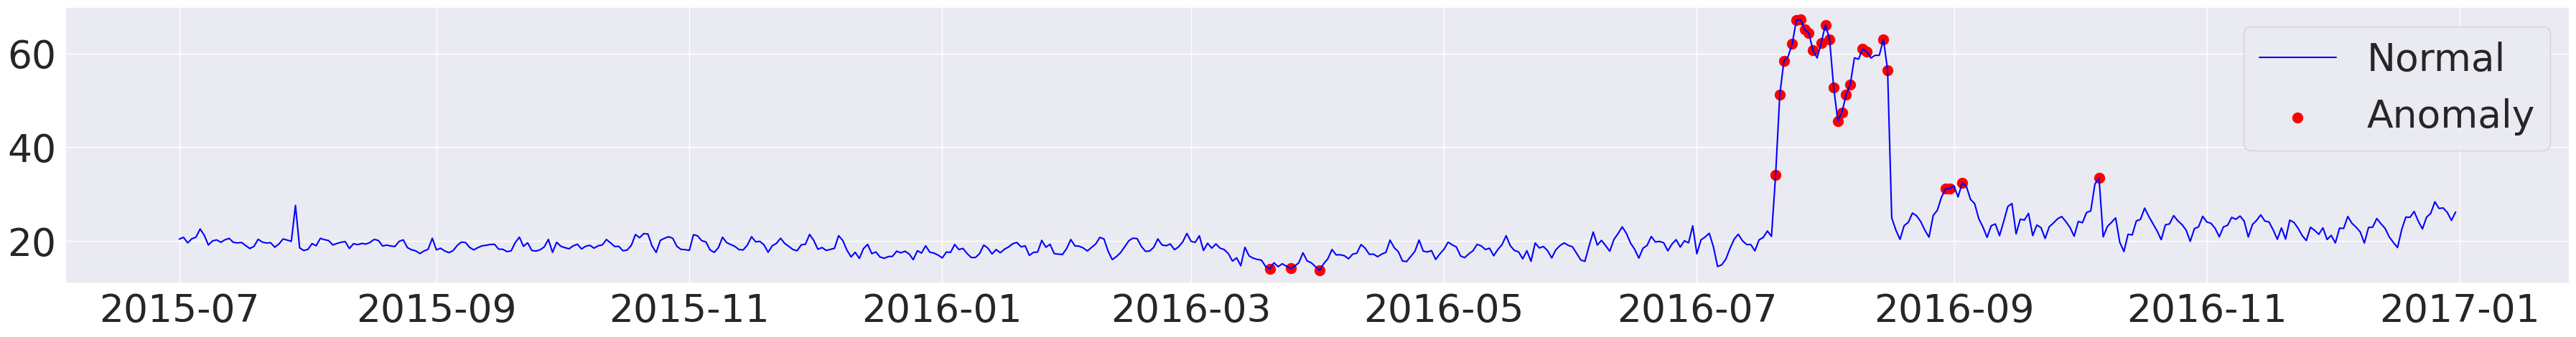

In [80]:
fig, ax = plt.subplots(figsize=(45,5))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Visits'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Visits'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

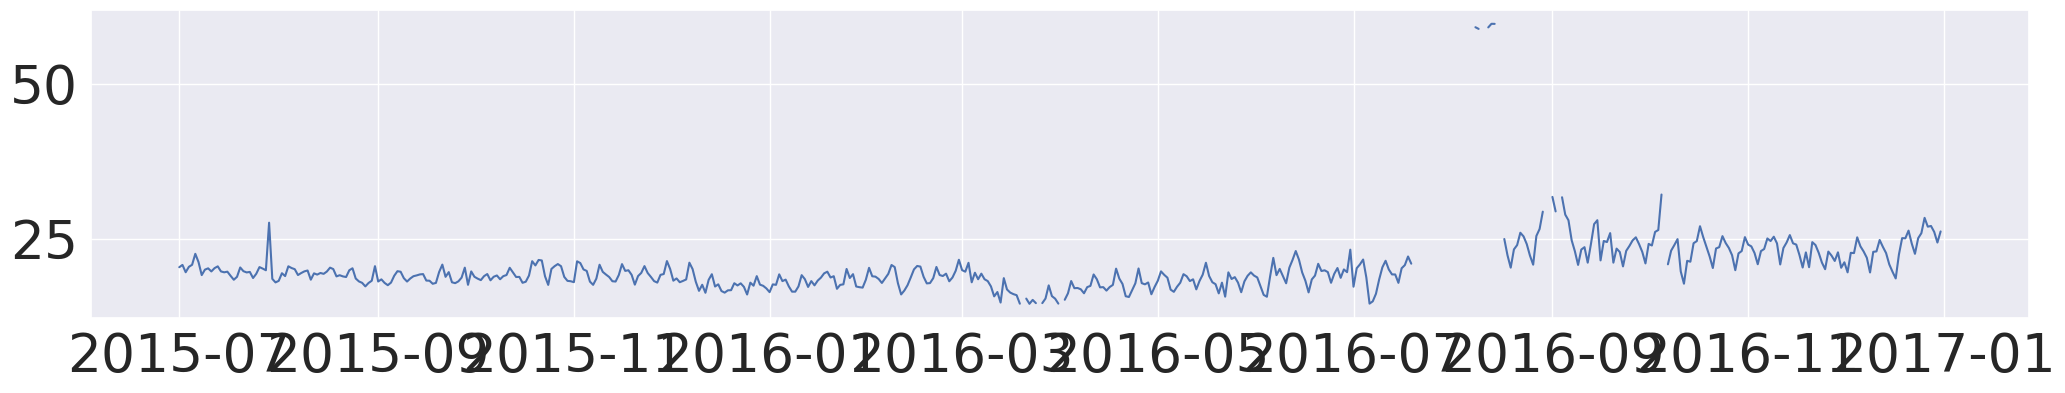

In [81]:
# Removing anomalies from the data
top_page_df['new_visits'] = top_page_df.apply(lambda row: row.Visits if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(25,4))
plt.plot(top_page_df.index,top_page_df.new_visits)

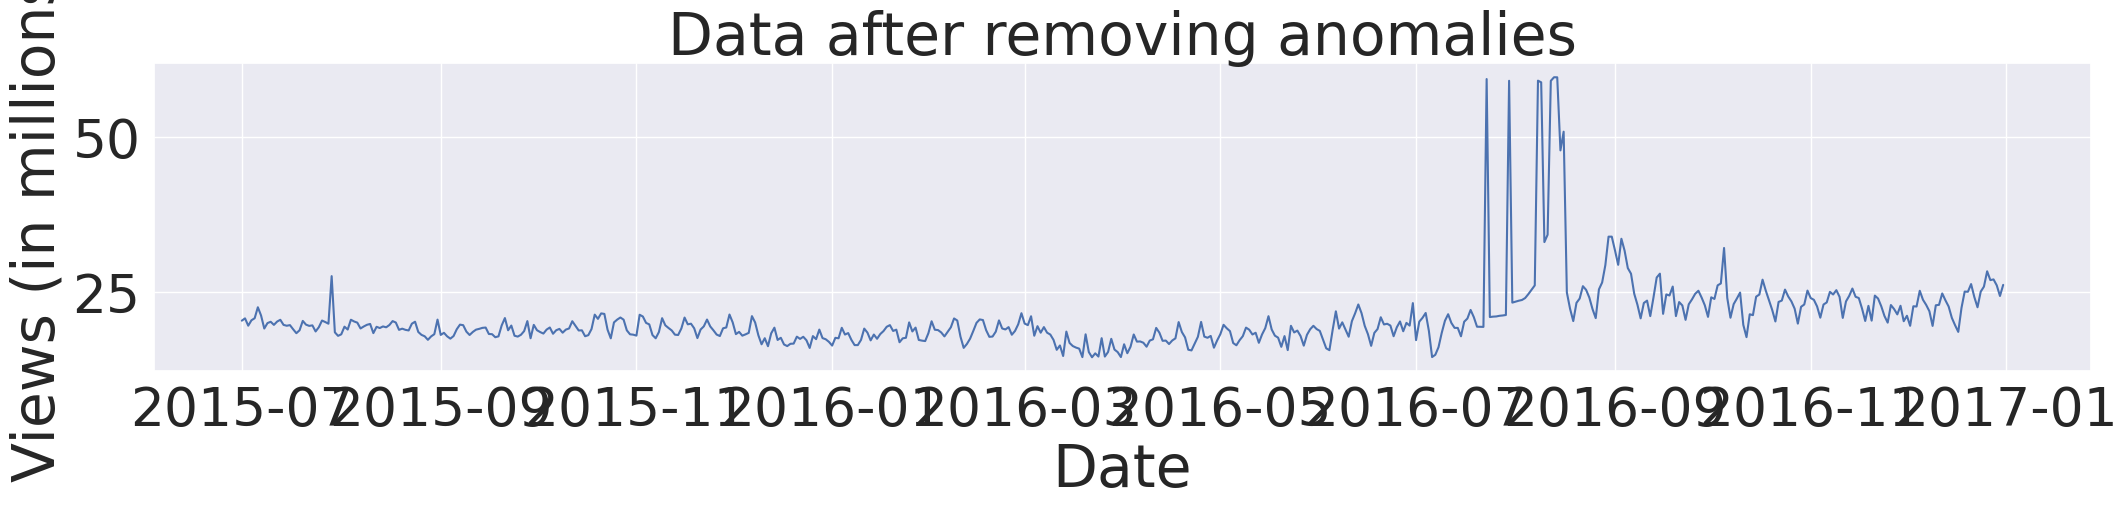

In [82]:
# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_visits.fillna(top_page_df.new_visits.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(25,4))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [83]:
top_page_df = top_page_df.drop(columns=['Visits','anomaly','new_visits']).rename(columns={'rolling_mean':'Views'})


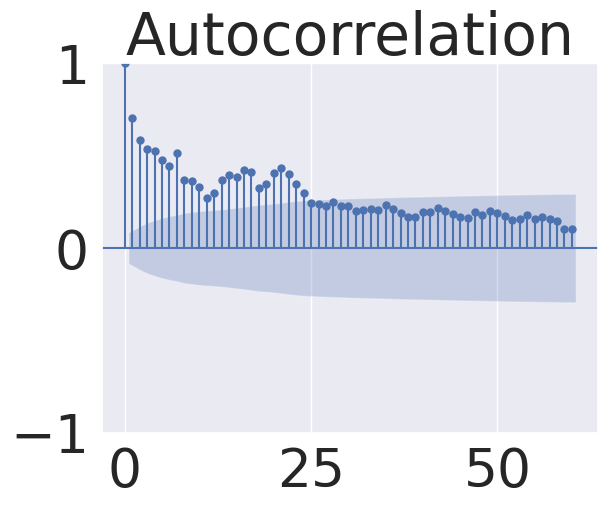

In [84]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

## Augmented Dicky Fuller Test
First element of output is the test statistic. Test statistic shows how likely the data is stationary
Second element indicates the p-value. If p-value is >0.05, reject null hypothesis or else not, The null hypothesis is that data is not stationary.

In [85]:
test = adfuller(top_page_df['Views'])
print(test)

(-2.234585201518242, 0.19393326710513575, 14, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 2847.5757094384535)


The data is not stationary as per the values.



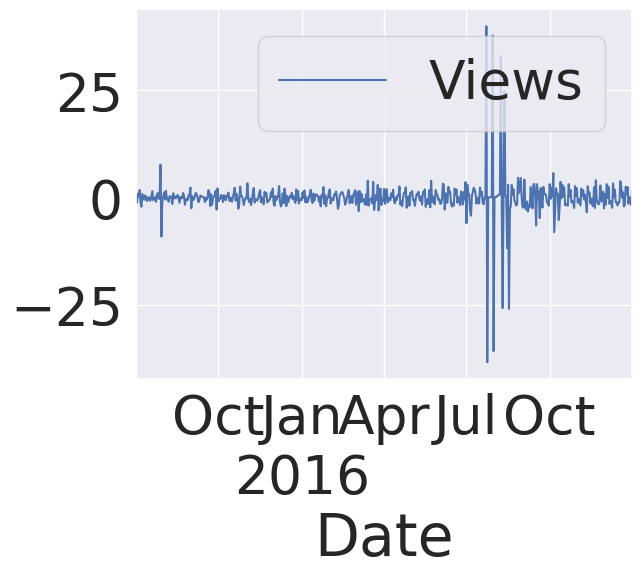

In [86]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

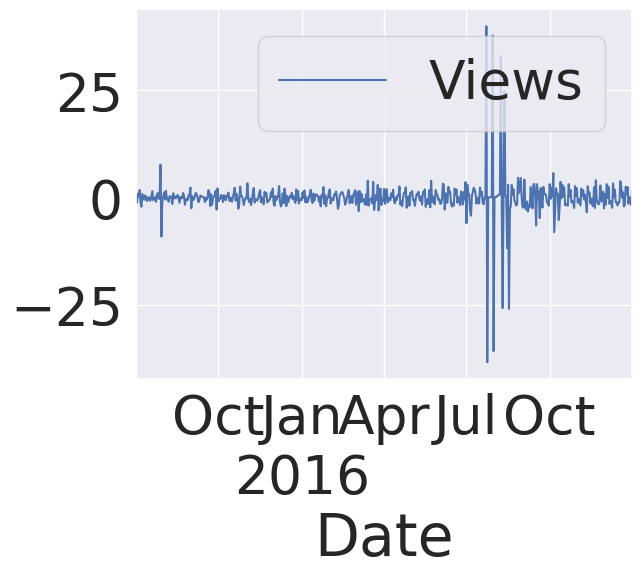

In [87]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [88]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-8.63206770847879, 5.719930335210942e-14, 19, 529, {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}, 2842.1340008829116)


Data is stationary



In [89]:
top_page_df


,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77
...,...
2016-12-27,26.92
2016-12-28,27.03
2016-12-29,26.07


In [90]:
# preparing data for modelling
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

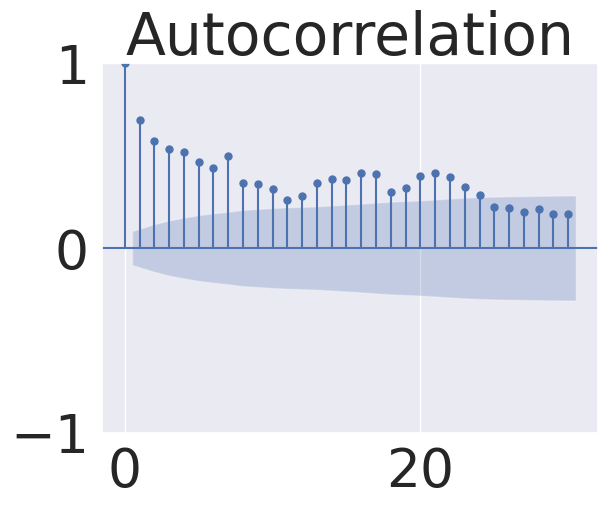

In [91]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

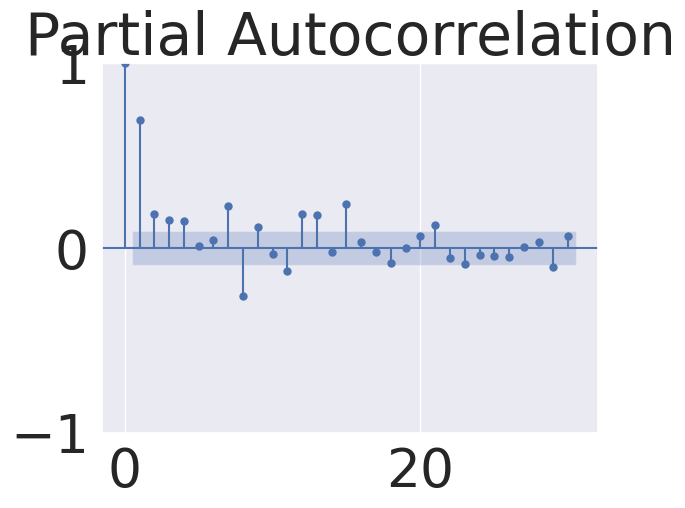

In [92]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## 4. ARMA Model


In [93]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
        except:
            continue

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46766D+00    |proj g|=  2.24709D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.247D-08   4.468D+00
  F =   4.4676567592984320     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.1

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  3.46675D+00    |proj g|=  1.17045D-01

At iterate   25    f=  3.46524D+00    |proj g|=  4.18250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   9.559D-06   3.465D+00
  F =   3.4652383783441336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03779D+00    |proj g|=  1.11437D-01

At iterate    5    f=  3.81118D+00    |proj g|=  4.14620D-01

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  3.17959D+00    |proj g|=  3.89987D-02

At iterate   20    f=  3.17886D+00    |proj g|=  2.52468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     32      1     0     0   7.074D-06   3.179D+00
  F =   3.1788464946327202     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01688D+00    |proj g|=  7.40923D-02

At iterate    5    f=  3.79383D+00    |proj g|=  1.82091D-01


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.25630D+00    |proj g|=  2.46498D-01

At iterate   15    f=  3.17381D+00    |proj g|=  4.01742D-02

At iterate   20    f=  3.16879D+00    |proj g|=  1.19452D-02

At iterate   25    f=  3.16840D+00    |proj g|=  1.78264D-03

At iterate   30    f=  3.16840D+00    |proj g|=  1.27880D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     38      1     0     0   1.279D-04   3.168D+00
  F =   3.1683993006699356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96208D+00    |proj g|=  3.24958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   5.767D-06   2.962D+00
  F =   2.9620779403200115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85888D+00    |proj g|=  6.64378D-02

At iterate    5    f=  2.83831D+00    |proj g|=  3.43774D-02

At iterate   10    f=  2.83505D+00    |proj g|=  2.73969D-03

At iterate   15    f=  2.83268D+00    |proj g|=  2.19643D-02

At iterate   20    f=  2.82639D+00    |proj g|=  5.65319D-03

At iterate   25    f=  2.82553D+00    |proj g|=  1.77114D-03

At iterate   30    f=  2.82553D+00    |proj g|=  9.01452D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  2.82779D+00    |proj g|=  1.19342D-02

At iterate   25    f=  2.82491D+00    |proj g|=  6.73171D-03

At iterate   30    f=  2.82453D+00    |proj g|=  7.25481D-04

At iterate   35    f=  2.82453D+00    |proj g|=  9.12120D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     38      1     0     0   6.035D-05   2.825D+00
  F =   2.8245268907854189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02172D+02    |proj g|=  4.47270D+02

At iterate    5    f=  3.22997D+00    |proj g|=  7.58981D-01

At iterate   10    f=  2.94741D+00    |proj g|=  2.55050D-02

At iterate   15    f=  2.87686D+00    |proj g|=  4.07370D-02

At iterate   20    f=  2.85675D+00    |proj g|=  2.99844D-02

At iterate   25    f=  2.85075D+00    |proj g|=  1.51875D-03

At iterate   30    f=  2.85036D+00    |proj g|=  4.84651D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   15    f=  3.55666D+00    |proj g|=  2.52303D-01

At iterate   20    f=  2.90221D+00    |proj g|=  1.44083D-01

At iterate   25    f=  2.85791D+00    |proj g|=  8.98336D-03

At iterate   30    f=  2.85381D+00    |proj g|=  2.20139D-03

At iterate   35    f=  2.85045D+00    |proj g|=  2.54263D-02

At iterate   40    f=  2.84965D+00    |proj g|=  1.51127D-04

At iterate   45    f=  2.84963D+00    |proj g|=  1.41366D-03

At iterate   50    f=  2.84962D+00    |proj g|=  8.72540D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   8.725D-05   2.850D+00
  F =   2.84962172679

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  2.84265D+00    |proj g|=  2.08612D-03

At iterate   20    f=  2.84229D+00    |proj g|=  6.76528D-04

At iterate   25    f=  2.84228D+00    |proj g|=  8.17049D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     28      1     0     0   8.170D-06   2.842D+00
  F =   2.8422835781131517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88009D+00    |proj g|=  1.83257D-01

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.84201D+00    |proj g|=  1.04018D-02

At iterate   15    f=  2.84090D+00    |proj g|=  1.17767D-03

At iterate   20    f=  2.84089D+00    |proj g|=  8.40104D-05

At iterate   25    f=  2.84089D+00    |proj g|=  9.01340D-04

At iterate   30    f=  2.84087D+00    |proj g|=  1.74246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     34      1     0     0   1.627D-05   2.841D+00
  F =   2.8408742448690742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80375D+00    |proj g|=  8.90232D-02

At iterate    5    f=  2.78627D+00    |proj g|=  2.11417D-02

At iterate   10    f=  2.78530D+00    |proj g|=  4.45565D-03

At iterate   15    f=  2.78528D+00    |proj g|=  1.42536D-04

At iterate   20    f=  2.78526D+00    |proj g|=  1.44333D-03

At iterate   25    f=  2.78509D+00    |proj g|=  1.14520D-03

At iterate   30    f=  2.78507D+00    |proj g|=  3.01904D-04

At iterate   35    f=  2.78507D+00    |proj g|=  9.36837D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88808D+00    |proj g|=  1.02115D-03

At iterate    5    f=  2.88807D+00    |proj g|=  4.16291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   3.378D-05   2.888D+00
  F =   2.8880730782828086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85714D+00    |proj g|=  2.76508D-02

At iterate    5    f=  2.85207D+00    |proj g|=  6.19938D-03

At iterate   10    f=  2.84556D+00    |proj g|=  1.33898D-02

At iterate   15    f=  2.84390D+00    |proj g|=  1.12460D-04

At iterate   20    f=  2.84390D+00    |proj g|=  1.15282D-03

At iterate   25    f=  2.84386D+00    |proj g|=  2.23945D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.79654D+00    |proj g|=  2.61281D-02

At iterate   15    f=  2.79319D+00    |proj g|=  6.00829D-02

At iterate   20    f=  2.79270D+00    |proj g|=  1.12777D-03

At iterate   25    f=  2.79269D+00    |proj g|=  1.30908D-04

At iterate   30    f=  2.79269D+00    |proj g|=  5.14875D-03

At iterate   35    f=  2.79268D+00    |proj g|=  1.86557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     46      1     0     0   2.956D-05   2.793D+00
  F =   2.7926818739257913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.82354D+00    |proj g|=  1.89336D-02

At iterate   15    f=  2.82352D+00    |proj g|=  1.02459D-02

At iterate   20    f=  2.82350D+00    |proj g|=  2.62514D-03

At iterate   25    f=  2.82266D+00    |proj g|=  4.55420D-02

At iterate   30    f=  2.81172D+00    |proj g|=  9.44050D-02

At iterate   35    f=  2.79606D+00    |proj g|=  5.16397D-02

At iterate   40    f=  2.79174D+00    |proj g|=  4.15726D-03

At iterate   45    f=  2.79160D+00    |proj g|=  4.68113D-04


/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.79159D+00    |proj g|=  4.48423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   4.484D-04   2.792D+00
  F =   2.7915945524578123     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79832D+00    |proj g|=  6.39254D-01

At iterate    5    f=  2.78372D+00    |proj g|=  1.52250D-01

At iterate   10    f=  2.78061D+00    |proj g|=  2.86146D-02

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred f


At iterate    5    f=  2.86793D+00    |proj g|=  3.16757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   3.148D-05   2.868D+00
  F =   2.8679278028981003     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87071D+00    |proj g|=  2.31217D-02

At iterate    5    f=  2.86868D+00    |proj g|=  1.18269D-02

At iterate   10    f=  2.86839D+00    |proj g|=  8.08311D-03

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  2.84216D+00    |proj g|=  3.47369D-02

At iterate   30    f=  2.84016D+00    |proj g|=  5.13215D-03

At iterate   35    f=  2.83971D+00    |proj g|=  2.36621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     46      1     0     0   5.327D-06   2.840D+00
  F =   2.8397088422446357     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58489D+01    |proj g|=  2.63351D+01

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.81794D+00    |proj g|=  4.70880D-02

At iterate   15    f=  2.79757D+00    |proj g|=  2.71503D-02

At iterate   20    f=  2.79551D+00    |proj g|=  1.88290D-02

At iterate   25    f=  2.79461D+00    |proj g|=  3.40596D-03

At iterate   30    f=  2.79372D+00    |proj g|=  9.01798D-03

At iterate   35    f=  2.79263D+00    |proj g|=  6.65055D-03

At iterate   40    f=  2.79235D+00    |proj g|=  3.89631D-04

At iterate   45    f=  2.79235D+00    |proj g|=  1.77624D-04

At iterate   50    f=  2.79235D+00    |proj g|=  8.94891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.80517D+00    |proj g|=  5.31611D-02

At iterate   15    f=  2.79311D+00    |proj g|=  1.87176D-02

At iterate   20    f=  2.79225D+00    |proj g|=  8.80977D-03

At iterate   25    f=  2.79205D+00    |proj g|=  6.91790D-03

At iterate   30    f=  2.79190D+00    |proj g|=  3.41634D-03

At iterate   35    f=  2.79184D+00    |proj g|=  3.82950D-03

At iterate   40    f=  2.79182D+00    |proj g|=  7.08654D-04

At iterate   45    f=  2.79166D+00    |proj g|=  8.20829D-03


/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.79005D+00    |proj g|=  1.96215D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   1.962D-01   2.790D+00
  F =   2.7900468742697369     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83743D+00    |proj g|=  8.76875D-01

At iterate    5    f=  2.83197D+00    |proj g|=  2.32673D-01

At iterate   10    f=  2.82992D+00    |proj g|=  1.86761D-01

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.82433D+00    |proj g|=  9.94473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     56      1     0     0   9.945D-03   2.824D+00
  F =   2.8243263403607104     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82528D+00    |proj g|=  1.09742D+00

At iterate    5    f=  2.81732D+00    |proj g|=  5.74342D-01

At iterate   10    f=  2.81521D+00    |proj g|=  2.61752D-01

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred f

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86639D+00    |proj g|=  2.05030D-03

At iterate    5    f=  2.86637D+00    |proj g|=  2.61068D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      8      1     0     0   2.609D-05   2.866D+00
  F =   2.8663662620365642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 v

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.84910D+00    |proj g|=  3.48939D-02

At iterate   10    f=  2.84450D+00    |proj g|=  4.24087D-03

At iterate   15    f=  2.84427D+00    |proj g|=  1.20809D-03

At iterate   20    f=  2.84350D+00    |proj g|=  1.79399D-02

At iterate   25    f=  2.84125D+00    |proj g|=  1.36807D-02

At iterate   30    f=  2.83987D+00    |proj g|=  5.89381D-03

At iterate   35    f=  2.83970D+00    |proj g|=  1.07528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     43      1     0     0   6.091D-06   2.840D+00
  F =   2.8397017645198090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.81712D+00    |proj g|=  1.90130D-02

At iterate   20    f=  2.81630D+00    |proj g|=  7.32046D-04

At iterate   25    f=  2.81628D+00    |proj g|=  6.75824D-04

At iterate   30    f=  2.81622D+00    |proj g|=  6.16779D-03

At iterate   35    f=  2.81595D+00    |proj g|=  1.05273D-02

At iterate   40    f=  2.81588D+00    |proj g|=  1.21370D-03

At iterate   45    f=  2.81586D+00    |proj g|=  1.67496D-04

At iterate   50    f=  2.81586D+00    |proj g|=  2.48374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   2.484D-04   2.816D+00
  F =   2.81585985343

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.82026D+00    |proj g|=  2.06640D-02

At iterate   10    f=  2.81256D+00    |proj g|=  8.68444D-03

At iterate   15    f=  2.79684D+00    |proj g|=  1.80744D-01

At iterate   20    f=  2.79202D+00    |proj g|=  1.87512D-02

At iterate   25    f=  2.78750D+00    |proj g|=  2.44062D-03

At iterate   30    f=  2.78719D+00    |proj g|=  9.42290D-03

At iterate   35    f=  2.78696D+00    |proj g|=  7.19280D-03

At iterate   40    f=  2.78655D+00    |proj g|=  1.28009D-02

At iterate   45    f=  2.78408D+00    |proj g|=  1.21021D-01

At iterate   50    f=  2.78160D+00    |proj g|=  6.32770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.78481D+00    |proj g|=  5.29972D-02

At iterate   15    f=  2.78204D+00    |proj g|=  5.22171D-02

At iterate   20    f=  2.78051D+00    |proj g|=  4.29444D-03

At iterate   25    f=  2.78017D+00    |proj g|=  5.39590D-03

At iterate   30    f=  2.78007D+00    |proj g|=  3.57056D-03

At iterate   35    f=  2.78005D+00    |proj g|=  2.21525D-03

At iterate   40    f=  2.78004D+00    |proj g|=  8.95984D-04

At iterate   45    f=  2.77999D+00    |proj g|=  4.99627D-03

At iterate   50    f=  2.77973D+00    |proj g|=  4.64180D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56   

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.77506D+00    |proj g|=  8.58144D-02

At iterate   15    f=  2.76514D+00    |proj g|=  3.74808D-02

At iterate   20    f=  2.76382D+00    |proj g|=  3.56680D-03

At iterate   25    f=  2.76367D+00    |proj g|=  3.62184D-03

At iterate   30    f=  2.76359D+00    |proj g|=  1.64043D-03

At iterate   35    f=  2.76348D+00    |proj g|=  1.43283D-02

At iterate   40    f=  2.76275D+00    |proj g|=  1.67431D-02

At iterate   45    f=  2.76166D+00    |proj g|=  2.22541D-02

At iterate   50    f=  2.76095D+00    |proj g|=  2.53248D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57   

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred f

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86310D+00    |proj g|=  2.43271D-03

At iterate    5    f=  2.86307D+00    |proj g|=  1.29533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8      1     0     0   1.902D-06   2.863D+00
  F =   2.8630711697153131     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 v

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  2.85639D+00    |proj g|=  3.97120D-02

At iterate   20    f=  2.84754D+00    |proj g|=  5.38894D-02

At iterate   25    f=  2.84080D+00    |proj g|=  4.82004D-02

At iterate   30    f=  2.83880D+00    |proj g|=  2.09641D-02

At iterate   35    f=  2.83771D+00    |proj g|=  1.55493D-02

At iterate   40    f=  2.83732D+00    |proj g|=  5.78964D-03

At iterate   45    f=  2.83709D+00    |proj g|=  1.01526D-02

At iterate   50    f=  2.83700D+00    |proj g|=  4.66358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64      1     0     0   4.664D-04   2.837D+00
  F =   2.83700052098

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete


At iterate    5    f=  2.89824D+00    |proj g|=  5.49190D-02

At iterate   10    f=  2.86845D+00    |proj g|=  1.34520D-01

At iterate   15    f=  2.81704D+00    |proj g|=  3.74271D-02

At iterate   20    f=  2.80853D+00    |proj g|=  1.11799D-02

At iterate   25    f=  2.80580D+00    |proj g|=  7.71412D-03

At iterate   30    f=  2.80327D+00    |proj g|=  1.67836D-02

At iterate   35    f=  2.79476D+00    |proj g|=  3.93763D-02

At iterate   40    f=  2.79146D+00    |proj g|=  4.42654D-03

At iterate   45    f=  2.78941D+00    |proj g|=  8.85222D-03

At iterate   50    f=  2.78848D+00    |proj g|=  5.66764D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.81455D+00    |proj g|=  5.10628D-02

At iterate   10    f=  2.77487D+00    |proj g|=  5.78355D-02

At iterate   15    f=  2.75514D+00    |proj g|=  1.66082D-02

At iterate   20    f=  2.75360D+00    |proj g|=  8.46440D-03

At iterate   25    f=  2.75287D+00    |proj g|=  4.51869D-03

At iterate   30    f=  2.75281D+00    |proj g|=  2.23362D-03

At iterate   35    f=  2.75240D+00    |proj g|=  1.14824D-02

At iterate   40    f=  2.75143D+00    |proj g|=  7.55028D-03

At iterate   45    f=  2.75122D+00    |proj g|=  8.23552D-03


/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.75118D+00    |proj g|=  1.27855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     54      1     0     0   1.279D-04   2.751D+00
  F =   2.7511844782978687     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92679D+00    |proj g|=  1.52983D+00

At iterate    5    f=  2.83717D+00    |proj g|=  9.46590D-01

At iterate   10    f=  2.82917D+00    |proj g|=  2.67767D-01

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17790D+00    |proj g|=  6.92754D-01

At iterate    5    f=  2.80160D+00    |proj g|=  7.53273D-02

At iterate   10    f=  2.77572D+00    |proj g|=  7.06762D-02

At iterate   15    f=  2.77164D+00    |proj g|=  6.02376D-02

At iterate   20    f=  2.77045D+00    |proj g|=  1.00138D-02

At iterate   25    f=  2.76991D+00    |proj g|=  2.04348D-02

At iterate   30    f=  2.76694D+00    |proj g|=  8.76488D-02

At iterate   35    f=  2.76390D+00    |proj g|=  3.06213D-02

At iterate   40    f=  2.75976D+00    |proj g|=  7.18303D-02

At iterate   45    f=  2.75814D+00    |proj g|=  1.35584D-02

At iterate   50    f=  2.75725D+00    |proj g|=  1.59612D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic','bic'])

In [95]:
# prediction using ARMA model
model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),0,int(aic_bic_df.iloc[0]['q'])))
result = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84495D+00    |proj g|=  4.37090D-01


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.81455D+00    |proj g|=  5.10628D-02

At iterate   10    f=  2.77487D+00    |proj g|=  5.78355D-02

At iterate   15    f=  2.75514D+00    |proj g|=  1.66082D-02

At iterate   20    f=  2.75360D+00    |proj g|=  8.46440D-03

At iterate   25    f=  2.75287D+00    |proj g|=  4.51869D-03

At iterate   30    f=  2.75281D+00    |proj g|=  2.23362D-03

At iterate   35    f=  2.75240D+00    |proj g|=  1.14824D-02

At iterate   40    f=  2.75143D+00    |proj g|=  7.55028D-03

At iterate   45    f=  2.75122D+00    |proj g|=  8.23552D-03

At iterate   50    f=  2.75118D+00    |proj g|=  1.27855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [96]:
import pickle
with open('arma_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [97]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

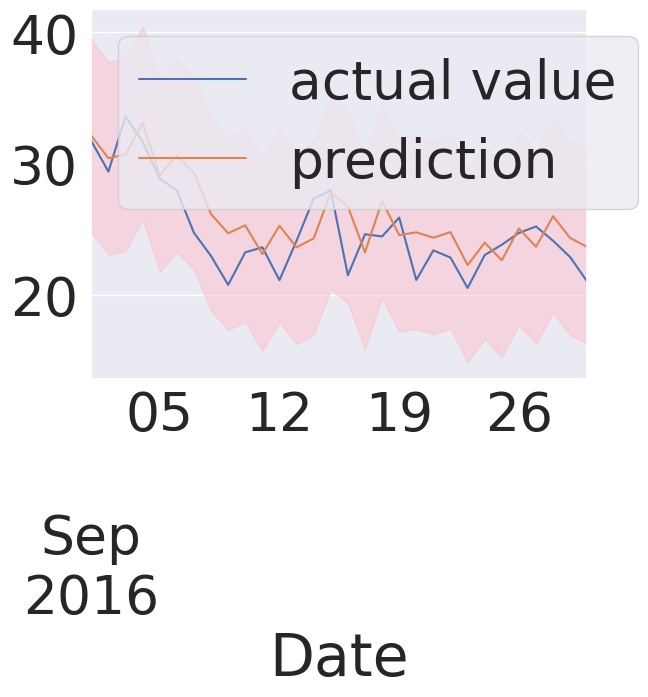

In [98]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

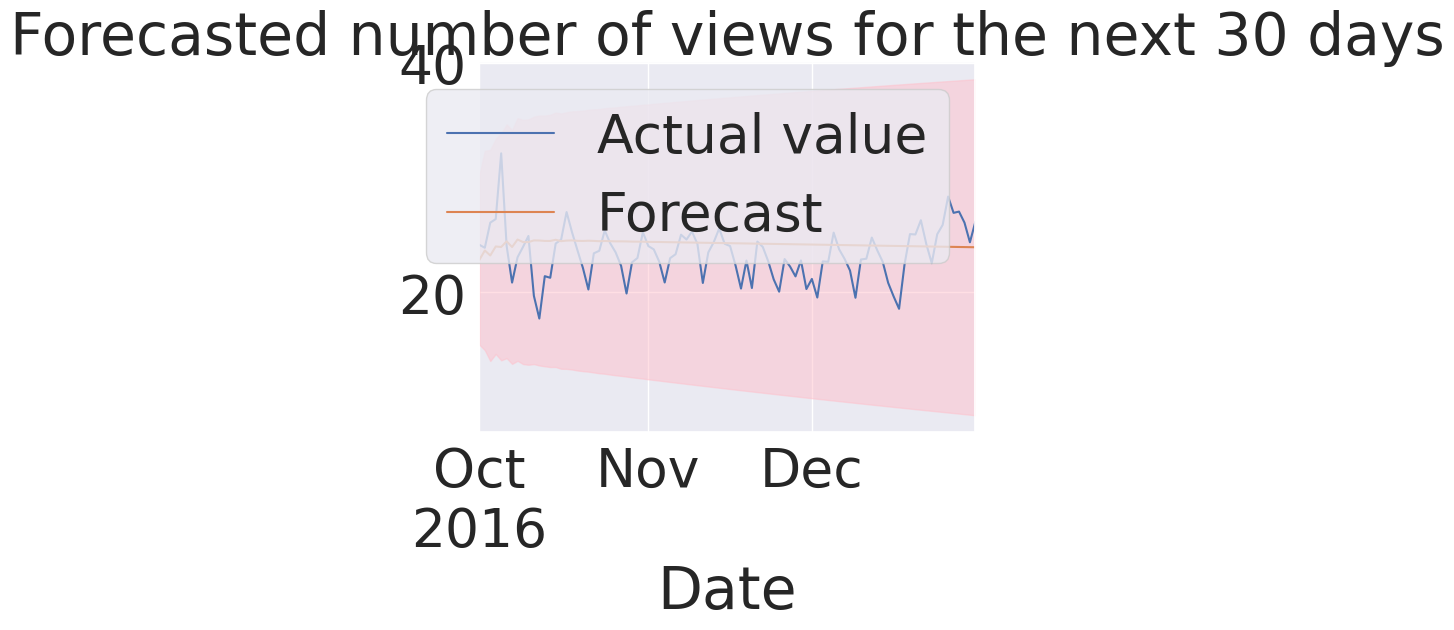

In [99]:
# forecasting using ARMA model
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [100]:
rmse_values = []
rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

In [101]:
print(rmse_values)

[('ARMA', 2.49356177941554)]


## 5. ARIMA Model


In [102]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic','bic'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95858D+00    |proj g|=  4.65281D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   8.455D-08   2.959D+00
  F =   2.9585800204736228     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, s


At iterate   10    f=  2.84250D+00    |proj g|=  4.26310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   2.323D-06   2.843D+00
  F =   2.8425019706925654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85073D+00    |proj g|=  7.21325D-02

At iterate    5    f=  2.81862D+00    |proj g|=  2.74401D-02

At iterate   10    f=  2.81583D+00    |proj g|=  1.52972D-03

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.81704D+00    |proj g|=  1.95552D-02

At iterate   10    f=  2.81487D+00    |proj g|=  6.33546D-03

At iterate   15    f=  2.81479D+00    |proj g|=  6.46293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     24      1     0     0   9.601D-05   2.815D+00
  F =   2.8147930335796785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90848D+00    |proj g|=  6.42628D-04

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, s


At iterate    5    f=  2.84100D+00    |proj g|=  3.82933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.822D-06   2.841D+00
  F =   2.8407186954658239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85282D+00    |proj g|=  3.36916D-02

At iterate    5    f=  2.84986D+00    |proj g|=  2.97632D-02

At iterate   10    f=  2.84030D+00    |proj g|=  1.36817D-02

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87693D+00    |proj g|=  2.03421D-01

At iterate    5    f=  2.83837D+00    |proj g|=  2.31664D-02

At iterate   10    f=  2.83371D+00    |proj g|=  2.22878D-02

At iterate   15    f=  2.83271D+00    |proj g|=  1.26820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     21      1     0     0   8.042D-06   2.833D+00
  F =   2.8327111653518235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.77709D+00    |proj g|=  1.55151D-02

At iterate   10    f=  2.77538D+00    |proj g|=  3.25829D-03

At iterate   15    f=  2.77532D+00    |proj g|=  2.72685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     19      1     0     0   1.881D-05   2.775D+00
  F =   2.7753228963670851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88038D+00    |proj g|=  9.73324D-04

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, s


At iterate    5    f=  2.84030D+00    |proj g|=  3.62195D-03

At iterate   10    f=  2.83982D+00    |proj g|=  1.44088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   2.242D-05   2.840D+00
  F =   2.8398197934721505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96999D+00    |proj g|=  3.79503D-01

At iterate    5    f=  2.84154D+00    |proj g|=  1.84900D-02

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  2.83635D+00    |proj g|=  1.68551D-03

At iterate   25    f=  2.83615D+00    |proj g|=  1.46080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   2.748D-05   2.836D+00
  F =   2.8361496336309613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82303D+00    |proj g|=  2.68888D-01

At iterate    5    f=  2.81880D+00    |proj g|=  9.41597D-02


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.81408D+00    |proj g|=  1.64777D-02

At iterate   15    f=  2.81308D+00    |proj g|=  2.67969D-03

At iterate   20    f=  2.81297D+00    |proj g|=  1.64026D-02

At iterate   25    f=  2.81253D+00    |proj g|=  7.70471D-02

At iterate   30    f=  2.80556D+00    |proj g|=  7.34940D-02

At iterate   35    f=  2.79141D+00    |proj g|=  3.34851D-02

At iterate   40    f=  2.79001D+00    |proj g|=  3.42465D-03

At iterate   45    f=  2.78997D+00    |proj g|=  1.47485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     57      1     0     0   6.714D-06   2.790D+00
  F =   2.78996577277

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.79497D+00    |proj g|=  8.13025D-02

At iterate   10    f=  2.77361D+00    |proj g|=  9.43503D-02

At iterate   15    f=  2.77086D+00    |proj g|=  2.04512D-02

At iterate   20    f=  2.77021D+00    |proj g|=  7.19514D-03

At iterate   25    f=  2.76989D+00    |proj g|=  4.92258D-03

At iterate   30    f=  2.76987D+00    |proj g|=  8.97607D-04

At iterate   35    f=  2.76987D+00    |proj g|=  2.67904D-04

At iterate   40    f=  2.76987D+00    |proj g|=  8.17162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     46      1     0     0   8.172D-05   2.770D+00
  F =   2.76987113747

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78570D+00    |proj g|=  1.08073D-01

At iterate    5    f=  2.76919D+00    |proj g|=  2.48157D-02

At iterate   10    f=  2.76682D+00    |proj g|=  7.10101D-03

At iterate   15    f=  2.76666D+00    |proj g|=  9.61842D-04

At iterate   20    f=  2.76632D+00    |proj g|=  7.43205D-03

At iterate   25    f=  2.76615D+00    |proj g|=  8.17020D-04

At iterate   30    f=  2.76614D+00    |proj g|=  1.59210D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97113D+00    |proj g|=  3.83193D-01

At iterate    5    f=  2.85034D+00    |proj g|=  1.88675D-02

At iterate   10    f=  2.83881D+00    |proj g|=  3.24279D-03

At iterate   15    f=  2.83673D+00    |proj g|=  1.45755D-02

At iterate   20    f=  2.83033D+00    |proj g|=  7.15847D-03

At iterate   25    f=  2.82999D+00    |proj g|=  1.54098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     28      1     0     0   

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.83090D+00    |proj g|=  3.30629D-02

At iterate   10    f=  2.82490D+00    |proj g|=  1.48939D-02

At iterate   15    f=  2.82142D+00    |proj g|=  5.52101D-03

At iterate   20    f=  2.82086D+00    |proj g|=  6.07655D-03

At iterate   25    f=  2.81794D+00    |proj g|=  1.02538D-02

At iterate   30    f=  2.81383D+00    |proj g|=  7.64436D-03

At iterate   35    f=  2.81007D+00    |proj g|=  4.63411D-03

At iterate   40    f=  2.80889D+00    |proj g|=  4.41399D-03

At iterate   45    f=  2.80847D+00    |proj g|=  1.38190D-03

At iterate   50    f=  2.80842D+00    |proj g|=  1.32655D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82889D+00    |proj g|=  6.84440D-01

At iterate    5    f=  2.82065D+00    |proj g|=  7.46811D-02

At iterate   10    f=  2.81498D+00    |proj g|=  1.17412D-02

At iterate   15    f=  2.81451D+00    |proj g|=  2.04490D-03

At iterate   20    f=  2.81450D+00    |proj g|=  3.69331D-03

At iterate   25    f=  2.81450D+00    |proj g|=  6.22892D-03

At iterate   30    f=  2.81438D+00    |proj g|=  6.89892D-03

At iterate   35    f=  2.81397D+00    |proj g|=  1.09448D-01

At iterate   40    f=  2.81210D+00    |proj g|=  5.25796D-02

At iterate   45    f=  2.81168D+00    |proj g|=  2.02623D-02

At iterate   50    f=  2.81133D+00    |proj g|=  7.13040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.81910D+00    |proj g|=  5.86517D-02

At iterate   10    f=  2.81231D+00    |proj g|=  3.87166D-02

At iterate   15    f=  2.80949D+00    |proj g|=  1.36344D-02

At iterate   20    f=  2.80204D+00    |proj g|=  1.25754D-01

At iterate   25    f=  2.79678D+00    |proj g|=  1.13540D-02

At iterate   30    f=  2.79333D+00    |proj g|=  3.94934D-02

At iterate   35    f=  2.78002D+00    |proj g|=  6.77733D-03

At iterate   40    f=  2.77879D+00    |proj g|=  1.90591D-03

At iterate   45    f=  2.77877D+00    |proj g|=  1.95140D-04

At iterate   50    f=  2.77877D+00    |proj g|=  2.82371D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.77284D+00    |proj g|=  1.87720D-02

At iterate   15    f=  2.75411D+00    |proj g|=  5.99972D-02

At iterate   20    f=  2.75092D+00    |proj g|=  1.72104D-02

At iterate   25    f=  2.74936D+00    |proj g|=  1.18388D-02

At iterate   30    f=  2.74884D+00    |proj g|=  2.40484D-03

At iterate   35    f=  2.74883D+00    |proj g|=  2.31671D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     36     40      1     0     0   2.068D-04   2.749D+00
  F =   2.7488306943497696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.85304D+00    |proj g|=  3.74213D-02

At iterate   10    f=  2.83932D+00    |proj g|=  2.89402D-02

At iterate   15    f=  2.83390D+00    |proj g|=  7.37290D-03

At iterate   20    f=  2.83347D+00    |proj g|=  1.37235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     25      1     0     0   9.084D-06   2.833D+00
  F =   2.8334641312616329     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.84055D+00    |proj g|=  2.94607D-02

At iterate   15    f=  2.83716D+00    |proj g|=  4.57590D-03

At iterate   20    f=  2.83225D+00    |proj g|=  2.35486D-02

At iterate   25    f=  2.83009D+00    |proj g|=  1.05785D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   1.409D-05   2.830D+00
  F =   2.8299812749114341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.82677D+00    |proj g|=  4.95142D-03

At iterate   10    f=  2.82319D+00    |proj g|=  2.76223D-02

At iterate   15    f=  2.82087D+00    |proj g|=  6.67854D-03

At iterate   20    f=  2.82056D+00    |proj g|=  1.08261D-03

At iterate   25    f=  2.82007D+00    |proj g|=  5.11166D-03

At iterate   30    f=  2.81743D+00    |proj g|=  1.58896D-02

At iterate   35    f=  2.81015D+00    |proj g|=  1.70659D-02

At iterate   40    f=  2.80725D+00    |proj g|=  8.85032D-03

At iterate   45    f=  2.80623D+00    |proj g|=  4.66086D-03


/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.80571D+00    |proj g|=  3.46690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   3.467D-04   2.806D+00
  F =   2.8057059788487950     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82664D+00    |proj g|=  1.89256D-01

At iterate    5    f=  2.81301D+00    |proj g|=  1.91782D-02

At iterate   10    f=  2.80721D+00    |proj g|=  3.86338D-02

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  2.76934D+00    |proj g|=  1.26577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   1.266D-04   2.769D+00
  F =   2.7693393131030404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83543D+00    |proj g|=  1.66488D-01

At iterate    5    f=  2.81470D+00    |proj g|=  1.81400D-02

At iterate   10    f=  2.80831D+00    |proj g|=  7.55585D-02

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.76936D+00    |proj g|=  2.65828D-02

At iterate   10    f=  2.75711D+00    |proj g|=  3.10577D-02

At iterate   15    f=  2.75461D+00    |proj g|=  2.75299D-02

At iterate   20    f=  2.75438D+00    |proj g|=  2.85366D-03

At iterate   25    f=  2.75415D+00    |proj g|=  1.08659D-02

At iterate   30    f=  2.75412D+00    |proj g|=  2.13745D-03

At iterate   35    f=  2.75411D+00    |proj g|=  1.51040D-03

At iterate   40    f=  2.75405D+00    |proj g|=  1.99784D-03

At iterate   45    f=  2.75400D+00    |proj g|=  4.00194D-03


/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred f


At iterate   50    f=  2.75397D+00    |proj g|=  1.44006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   1.440D-03   2.754D+00
  F =   2.7539664958269601     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85433D+00    |proj g|=  2.41864D-03

At iterate    5    f=  2.85430D+00    |proj g|=  1.34629D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.84150D+00    |proj g|=  2.85161D-02

At iterate   15    f=  2.83377D+00    |proj g|=  5.26296D-03

At iterate   20    f=  2.83339D+00    |proj g|=  6.89624D-04

At iterate   25    f=  2.83326D+00    |proj g|=  8.10640D-03

At iterate   30    f=  2.83315D+00    |proj g|=  5.95344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     36      1     0     0   9.477D-06   2.833D+00
  F =   2.8331513538902913     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  2.81091D+00    |proj g|=  7.67166D-03

At iterate   20    f=  2.80585D+00    |proj g|=  1.22270D-02

At iterate   25    f=  2.80410D+00    |proj g|=  8.51258D-03

At iterate   30    f=  2.80014D+00    |proj g|=  7.93440D-02

At iterate   35    f=  2.78246D+00    |proj g|=  6.35072D-02

At iterate   40    f=  2.77893D+00    |proj g|=  8.15366D-03

At iterate   45    f=  2.77841D+00    |proj g|=  1.72766D-03

At iterate   50    f=  2.77840D+00    |proj g|=  6.12295D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     69      1     0     0   6.123D-05   2.778D+00
  F =   2.77839933777

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.79659D+00    |proj g|=  2.42939D-02

At iterate   15    f=  2.78321D+00    |proj g|=  2.89441D-02

At iterate   20    f=  2.76364D+00    |proj g|=  3.23808D-02

At iterate   25    f=  2.75135D+00    |proj g|=  3.31165D-02

At iterate   30    f=  2.74440D+00    |proj g|=  5.76020D-02

At iterate   35    f=  2.74222D+00    |proj g|=  1.70162D-02

At iterate   40    f=  2.74169D+00    |proj g|=  2.76050D-02

At iterate   45    f=  2.74139D+00    |proj g|=  7.55441D-03

At iterate   50    f=  2.74137D+00    |proj g|=  1.84661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     65   

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.79014D+00    |proj g|=  3.72326D-02

At iterate   15    f=  2.76706D+00    |proj g|=  8.31178D-02

At iterate   20    f=  2.75605D+00    |proj g|=  1.26772D-02

At iterate   25    f=  2.75077D+00    |proj g|=  1.51284D-02

At iterate   30    f=  2.74856D+00    |proj g|=  1.06733D-02

At iterate   35    f=  2.74631D+00    |proj g|=  3.56056D-02

At iterate   40    f=  2.74438D+00    |proj g|=  8.45911D-03

At iterate   45    f=  2.74044D+00    |proj g|=  9.61743D-03

At iterate   50    f=  2.73916D+00    |proj g|=  1.50439D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58   

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79193D+00    |proj g|=  5.58313D-01

At iterate    5    f=  2.78749D+00    |proj g|=  6.66688D-02

At iterate   10    f=  2.78334D+00    |proj g|=  2.25853D-02

At iterate   15    f=  2.78049D+00    |proj g|=  1.85226D-02

At iterate   20    f=  2.77657D+00    |proj g|=  1.58655D-01

At iterate   25    f=  2.77229D+00    |proj g|=  3.89956D-02

At iterate   30    f=  2.76914D+00    |proj g|=  1.12225D-01

At iterate   35    f=  2.76839D+00    |proj g|=  3.11801D-02

At iterate   40    f=  2.76746D+00    |proj g|=  2.92647D-02

At iterate   45    f=  2.76592D+00    |proj g|=  1.15660D-01


/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred f


At iterate   50    f=  2.76225D+00    |proj g|=  1.05207D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   1.052D-01   2.762D+00
  F =   2.7622474991378483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82047D+00    |proj g|=  3.10597D-03

At iterate    5    f=  2.82043D+00    |proj g|=  1.56418D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83686D+00    |proj g|=  6.24984D-02

At iterate    5    f=  2.82041D+00    |proj g|=  5.96013D-02

At iterate   10    f=  2.80958D+00    |proj g|=  1.35564D-02

At iterate   15    f=  2.80672D+00    |proj g|=  1.24889D-02

At iterate   20    f=  2.80582D+00    |proj g|=  1.86246D-04

At iterate   25    f=  2.80582D+00    |proj g|=  2.88218D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     30      1     0     0   

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.77453D+00    |proj g|=  3.95702D-02

At iterate   15    f=  2.76682D+00    |proj g|=  1.59321D-02

At iterate   20    f=  2.76634D+00    |proj g|=  2.31606D-03

At iterate   25    f=  2.76625D+00    |proj g|=  6.24491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     29     33      1     0     0   1.189D-05   2.766D+00
  F =   2.7662517268417628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iter

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.75007D+00    |proj g|=  2.94733D-02

At iterate   15    f=  2.74299D+00    |proj g|=  1.34068D-02

At iterate   20    f=  2.74072D+00    |proj g|=  8.31152D-03

At iterate   25    f=  2.73910D+00    |proj g|=  7.31403D-03

At iterate   30    f=  2.73902D+00    |proj g|=  1.36714D-03

At iterate   35    f=  2.73900D+00    |proj g|=  2.91531D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     36     45      1     0     0   1.008D-05   2.739D+00
  F =   2.7390016133791653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.74646D+00    |proj g|=  9.39767D-02

At iterate   15    f=  2.74105D+00    |proj g|=  1.35647D-02

At iterate   20    f=  2.73993D+00    |proj g|=  8.14472D-03

At iterate   25    f=  2.73890D+00    |proj g|=  5.28392D-03

At iterate   30    f=  2.73872D+00    |proj g|=  8.98779D-04

At iterate   35    f=  2.73865D+00    |proj g|=  4.46693D-03

At iterate   40    f=  2.73859D+00    |proj g|=  1.02054D-03

At iterate   45    f=  2.73859D+00    |proj g|=  1.05825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     47     53      1     0     0   3.604D-05   2.739D+00
  F =   2.73858601941

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.76989D+00    |proj g|=  1.90484D-02

At iterate   10    f=  2.75462D+00    |proj g|=  5.00585D-02

At iterate   15    f=  2.74248D+00    |proj g|=  3.35432D-02

At iterate   20    f=  2.74026D+00    |proj g|=  9.93420D-03

At iterate   25    f=  2.73925D+00    |proj g|=  1.07039D-02

At iterate   30    f=  2.73890D+00    |proj g|=  1.48278D-02

At iterate   35    f=  2.73855D+00    |proj g|=  1.62349D-03

At iterate   40    f=  2.73853D+00    |proj g|=  6.29400D-04

At iterate   45    f=  2.73853D+00    |proj g|=  3.06762D-04

At iterate   50    f=  2.73853D+00    |proj g|=  1.68379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [103]:
#predict using arima
arima_model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),1,int(aic_bic_df.iloc[0]['q'])))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82574D+00    |proj g|=  1.59233D-01

At iterate    5    f=  2.77596D+00    |proj g|=  6.64781D-02

At iterate   10    f=  2.75007D+00    |proj g|=  2.94733D-02

At iterate   15    f=  2.74299D+00    |proj g|=  1.34068D-02

At iterate   20    f=  2.74072D+00    |proj g|=  8.31152D-03

At iterate   25    f=  2.73910D+00    |proj g|=  7.31403D-03

At iterate   30    f=  2.73902D+00    |proj g|=  1.36714D-03

At iterate   35    f=  2.73900D+00    |proj g|=  2.91531D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [104]:
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

<Figure size 2400x400 with 0 Axes>

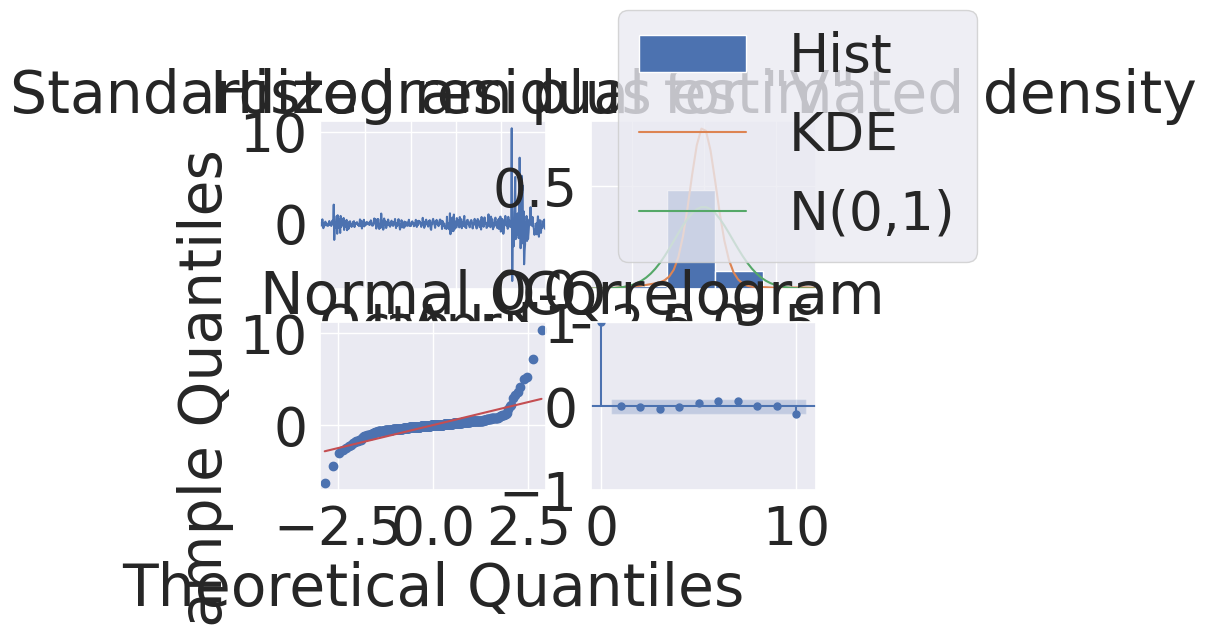

In [105]:
plt.figure(figsize=(24,4))

arima_result.plot_diagnostics()
plt.show()

In [106]:
arima_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -1254.463
Date:                Wed, 26 Jul 2023   AIC                           2530.925
Time:                        00:36:05   BIC                           2576.297
Sample:                    07-01-2015   HQIC                          2548.797
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3271      0.056    -23.785      0.000      -1.436      -1.218
ar.L2         -0.7091      0.064    -11.156      0.000      -0.834      -0.584
ar.L3          0.1703      0.090      1.897      0.058      -0.006       0.346
ar.L4          0.5067      0.088      5.777      0.000       0.335       0.679
ar.L5          0.1880      0.060      3.128      0.002       0.070       0.306
ar.L6         -0.0956      0.032     -3.032      0.002      -0.157      -0.034
ma.L1          0.9628      0.056     17.184      0.000       0.853       1.073
ma.L2          0.0193      0.035      0.556      0.578      -0.049       0.087
ma.L3         -0.8887      0.041    -21.609      0.000      -0.969      -0.808
ma.L4         -0.6908      0.057    -12.154      0.000      -0.802      -0.579
sigma2        14.0972      0.245     57.639      0.000      13.618      14.577
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             27329.38
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              16.94   Skew:                             3.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

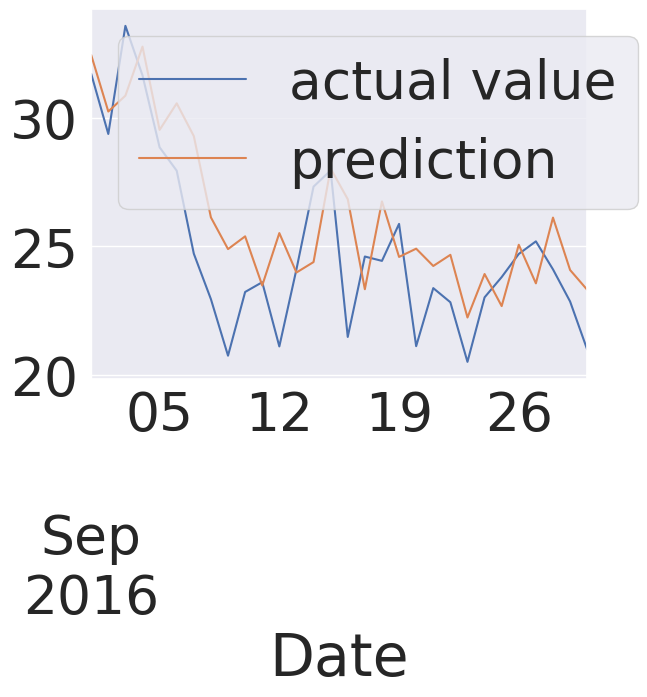

In [107]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

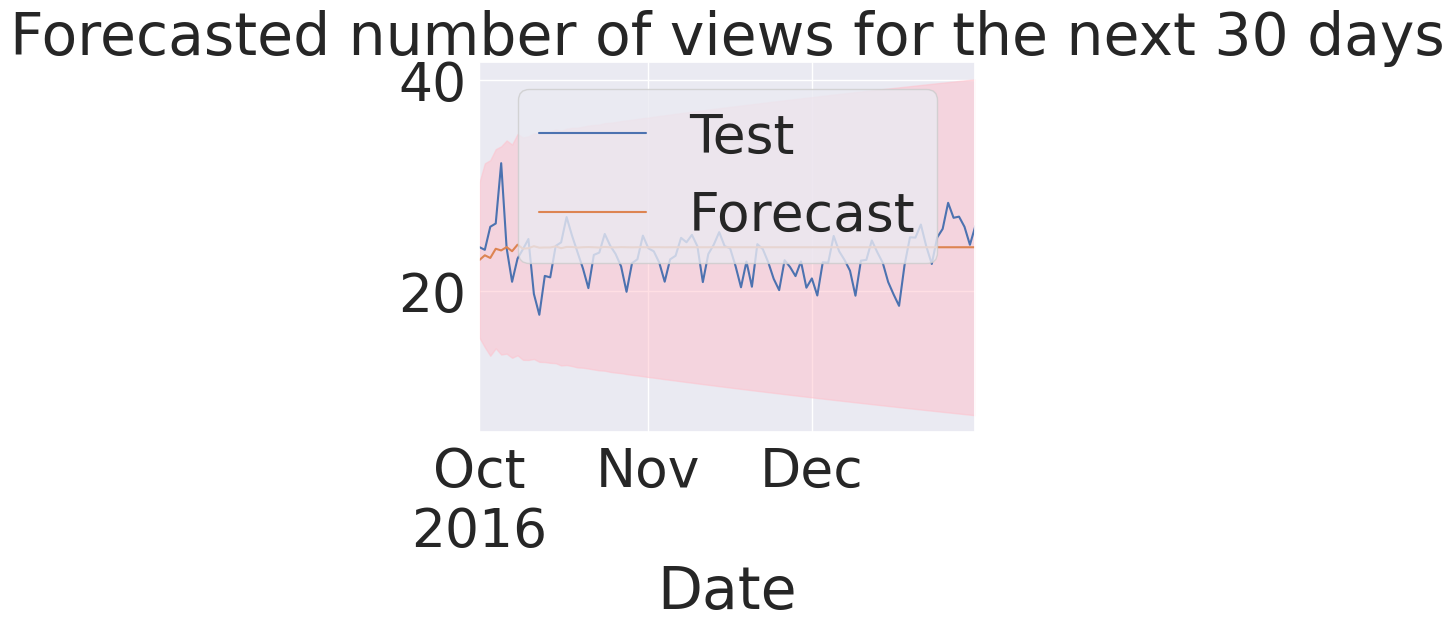

In [108]:
# Forecasting using ARIMA moidel
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [109]:
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))


## 6. Exponential smoothing model


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


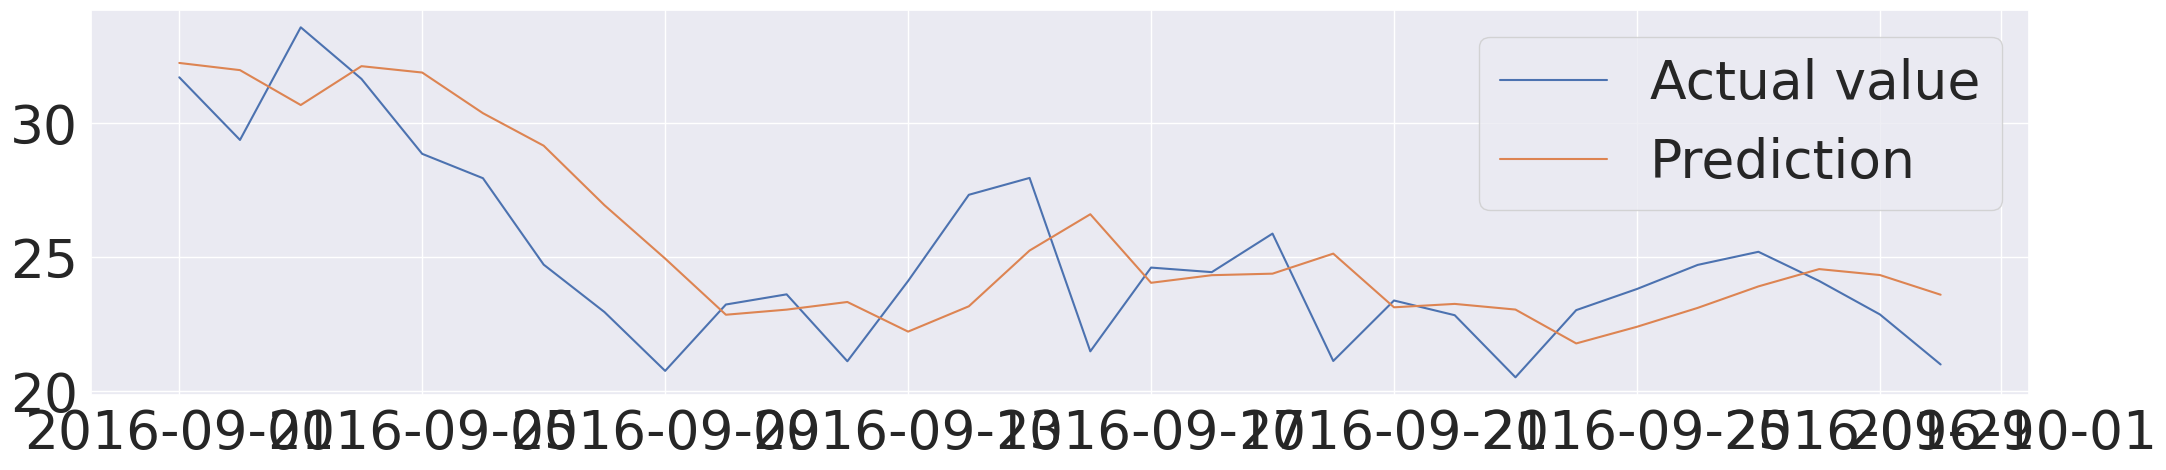

In [110]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)

# Prediction using Exponential Smoothing model
exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])

plt.figure(figsize=(25,5))
plt.plot(train[-30:], label='Actual value')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

In [111]:
with open('exp_smoothing_model.pkl', 'wb') as f:
    pickle.dump(exp_smoothing_model, f)

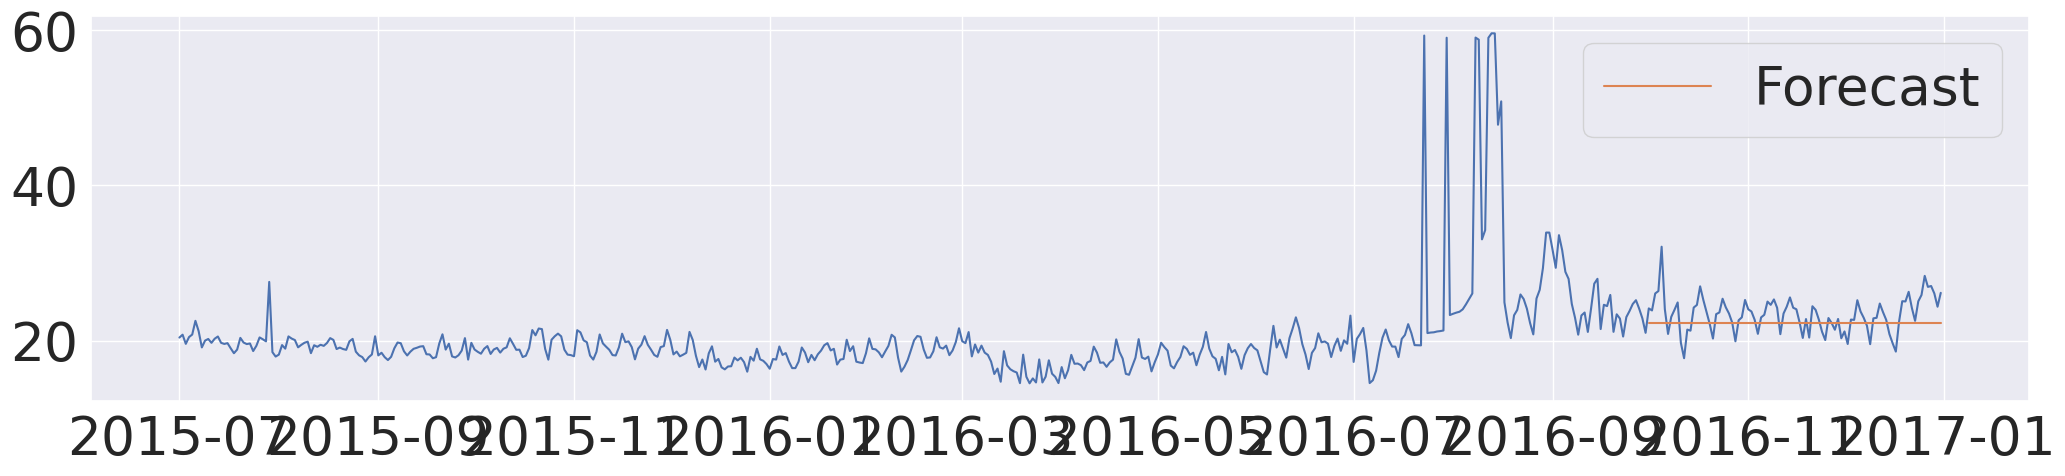

In [112]:
# Forecasting using Exponential smoothing model
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])
plt.figure(figsize=(25,5))

plt.plot(top_page_df)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [113]:
rmse_values.append(('Exponential Smoothing',np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))


## 8. Auto Arima


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2609.476, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2714.059, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2670.167, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2630.570, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2712.059, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2610.601, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2611.227, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2606.210, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2611.479, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2608.196, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2609.125, Time=0.32 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2604.2

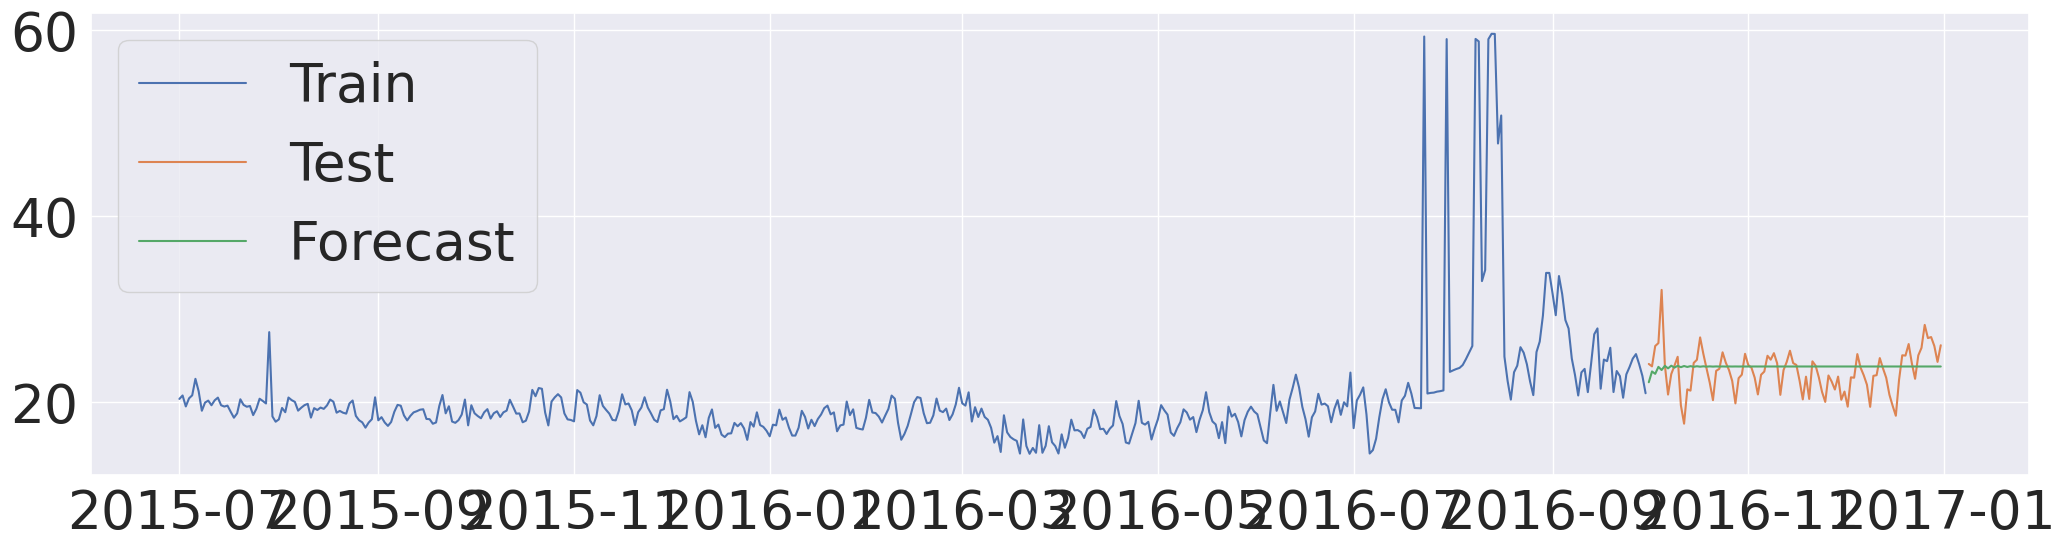

In [114]:
auto_arima_model = auto_arima(train,start_p=2,max_p=7,start_q=2,max_q=7, m=1,stationary=False,trace=True, seasonal=False,error_action='ignore',suppress_warnings=True)
auto_arima_model.fit(train)

auto_arima_forecast = auto_arima_model.predict(n_periods=test.shape[0])
auto_arima_forecast = pd.DataFrame(auto_arima_forecast,index = test.index,columns=['Forecast'])

plt.figure(figsize=(25,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(auto_arima_forecast, label='Forecast')
plt.legend()
plt.show()

In [115]:
with open('auto_arima_model.pkl', 'wb') as f:
    pickle.dump(auto_arima_model, f)

In [116]:
rmse_values.append(('Auto-arima',np.sqrt(np.mean(np.square(auto_arima_forecast.values - test.Views.values)))))


Compairing RMSE values

In [117]:
# RMSE
rmse_df = pd.DataFrame(rmse_values,columns=['Model','RMSE_values']).sort_values('RMSE_values')
rmse_df

,Model,RMSE_values
3,Auto-arima,2.323511
1,ARIMA,2.419388
0,ARMA,2.493562
2,Exponential Smoothing,2.493654


## 9. LSTMs


In [118]:
def transform_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [119]:
time_steps = 10


In [120]:
X_train, y_train = transform_dataset(train, train.Views, time_steps)
X_test, y_test = transform_dataset(test, test.Views, time_steps)

In [121]:
# Build the model
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=256,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.RMSprop()
)

In [122]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/200
26/26 [==============================] - 3s 36ms/step - loss: 88.1938 - val_loss: 19.1034
Epoch 2/200
26/26 [==============================] - 0s 15ms/step - loss: 37.0606 - val_loss: 17.6286
Epoch 3/200
26/26 [==============================] - 0s 14ms/step - loss: 33.4731 - val_loss: 13.5973
Epoch 4/200
26/26 [==============================] - 0s 14ms/step - loss: 34.1685 - val_loss: 12.9859
Epoch 5/200
26/26 [==============================] - 0s 14ms/step - loss: 32.2034 - val_loss: 12.6876
Epoch 6/200
26/26 [==============================] - 0s 14ms/step - loss: 31.2012 - val_loss: 14.0859
Epoch 7/200
26/26 [==============================] - 0s 14ms/step - loss: 29.6468 - val_loss: 16.9858
Epoch 8/200
26/26 [==============================] - 0s 14ms/step - loss: 29.0191 - val_loss: 20.4501
Epoch 9/200
26/26 [==============================] - 0s 14ms/step - loss: 28.4317 - val_loss: 25.2648
Epoch 10/200
26/26 [==============================] - 0s 14ms/step - loss: 27.6015

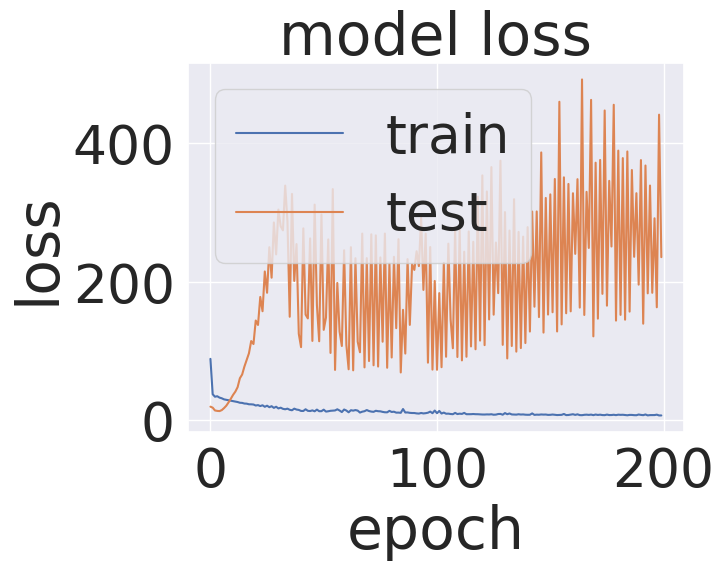

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [124]:

# Forecasting using test data
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 6ms/step


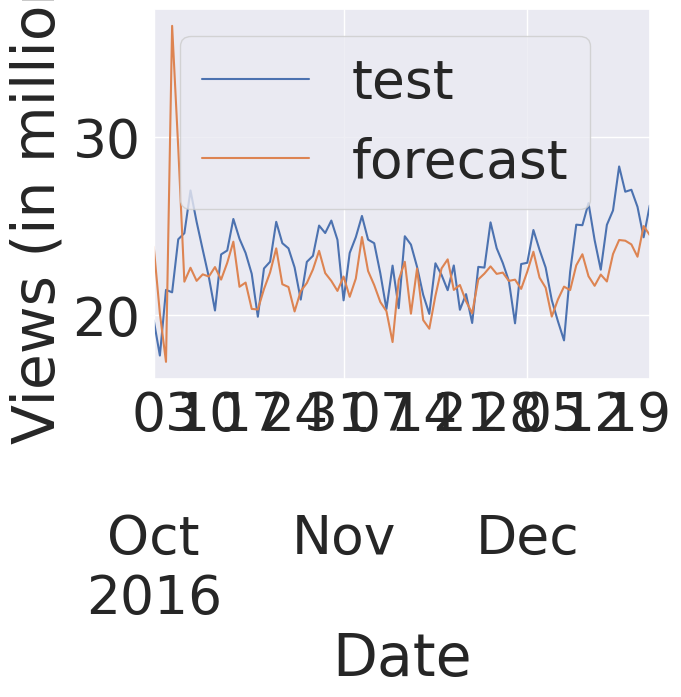

In [125]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [126]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))


RMSE:2.719666660452978


## 10. CNN1D


In [127]:
n_features=1
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [128]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/200
26/26 [==============================] - 1s 8ms/step - loss: 105.8699 - val_loss: 218.1449
Epoch 2/200
26/26 [==============================] - 0s 3ms/step - loss: 20.2992 - val_loss: 130.9800
Epoch 3/200
26/26 [==============================] - 0s 3ms/step - loss: 19.5792 - val_loss: 124.1729
Epoch 4/200
26/26 [==============================] - 0s 3ms/step - loss: 17.9057 - val_loss: 130.3801
Epoch 5/200
26/26 [==============================] - 0s 3ms/step - loss: 17.9082 - val_loss: 129.1643
Epoch 6/200
26/26 [==============================] - 0s 3ms/step - loss: 17.6755 - val_loss: 132.3807
Epoch 7/200
26/26 [==============================] - 0s 3ms/step - loss: 17.4080 - val_loss: 130.0908
Epoch 8/200
26/26 [==============================] - 0s 3ms/step - loss: 17.0192 - val_loss: 138.1445
Epoch 9/200
26/26 [==============================] - 0s 3ms/step - loss: 17.0257 - val_loss: 132.2147
Epoch 10/200
26/26 [==============================] - 0s 3ms/step - loss: 16.5922

In [129]:
#forecasting
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 2ms/step


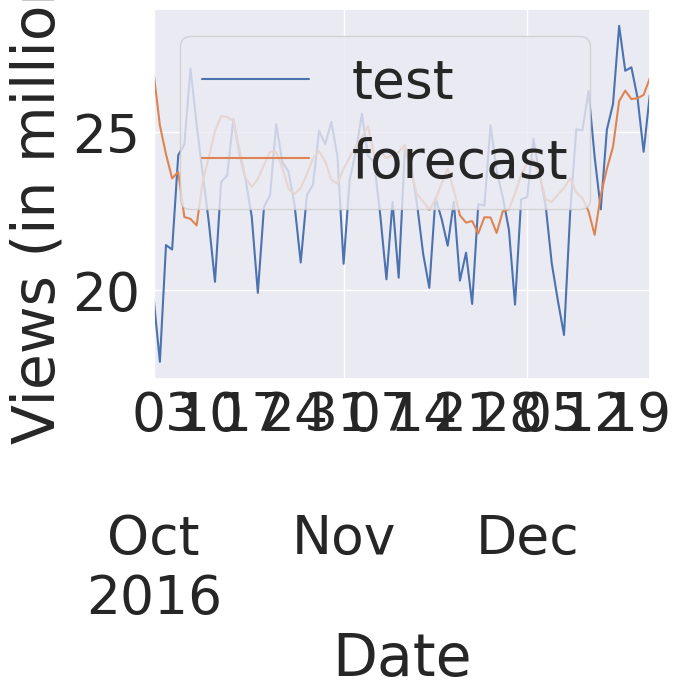

In [130]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [131]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))


RMSE:2.2334065556840805


## Conclusion

LSTMs outperforms all approaches.